# Violence Detection in Text Using BERT-based Analysis
## A Comprehensive Report on Hate Speech Classification

**Authors:** Hamza Khaled Mahmoud Ahmed, Soultan Toure Salifou, Maher Balchi
**Date:** June 21, 2025  
**Course:** Social Media Computing Assignment  

---

## Executive Summary

This report presents a comprehensive analysis of violence detection in text data using BERT-based natural language processing techniques. The study implements a machine learning pipeline that includes data preprocessing, exploratory data analysis, BERT embeddings generation, and classification using logistic regression. The analysis is performed on a balanced hate speech dataset to classify content as violent or non-violent.

---

## Table of Contents

1. [Environment Setup & GPU Configuration](#1-environment-setup--gpu-configuration)
2. [Data Loading & Initial Exploration](#2-data-loading--initial-exploration)
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Data Visualization](#5-data-visualization)
6. [Advanced Text Analysis: Opinion Mining & ABSA](#6-advanced-text-analysis-opinion-mining--absa)
7. [Feature Engineering with BERT](#7-feature-engineering-with-bert)
8. [Model Training](#8-model-training)
9. [Model Evaluation](#9-model-evaluation)
10. [Results Visualization](#10-results-visualization)
11. [Conclusions](#11-conclusions)

---

## 1. Environment Setup & GPU Configuration

This section verifies the computational environment and tests GPU availability for accelerated processing.

In [1]:
# Basic GPU availability check
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

CUDA available: True
Device: NVIDIA GeForce RTX 5060 Ti
GPU Memory: 15.9 GB


In [2]:
# Comprehensive GPU Performance Testing
import torch
import time

# --- GPU Performance Benchmarking ---
if not torch.cuda.is_available():
    print("⚠️  GPU not available. Using CPU for computations.")
else:
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"📊 VRAM Total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print("-" * 60)

    def report_gpu_memory(message=""):
        """Reports current GPU memory usage."""
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"{message} - VRAM: {allocated:.2f}GB allocated | {reserved:.2f}GB reserved")

    # Performance Comparison: CPU vs GPU
    print("\n🔬 Performance Benchmark: Matrix Multiplication")
    matrix_size = 8000
    
    # CPU Test
    print(f"Creating {matrix_size}×{matrix_size} matrices...")
    a_cpu = torch.randn(matrix_size, matrix_size)
    b_cpu = torch.randn(matrix_size, matrix_size)
    
    start_time = time.time()
    result_cpu = torch.matmul(a_cpu, b_cpu)
    cpu_time = time.time() - start_time
    print(f"⏱️  CPU Time: {cpu_time:.4f} seconds")
    
    # GPU Test
    a_gpu = a_cpu.to('cuda')
    b_gpu = b_cpu.to('cuda')
    report_gpu_memory("After GPU transfer")
    
    torch.cuda.synchronize()
    start_time = time.time()
    result_gpu = torch.matmul(a_gpu, b_gpu)
    torch.cuda.synchronize()
    gpu_time = time.time() - start_time
    print(f"🚀 GPU Time: {gpu_time:.4f} seconds")
    print(f"🎯 Speedup: {cpu_time / gpu_time:.1f}x faster on GPU")
    
    # Memory stress test
    print(f"\n💾 VRAM Utilization Test")
    report_gpu_memory("Before large tensor")
    
    target_gb = 8  # Conservative estimate
    try:
        num_elements = int((target_gb * 1024**3) / 4)
        large_tensor = torch.randn(num_elements, device='cuda')
        report_gpu_memory("After creating large tensor")
        print(f"✅ Successfully allocated {target_gb}GB tensor")
        
        # Clean up
        del large_tensor, a_gpu, b_gpu, result_gpu
        torch.cuda.empty_cache()
        report_gpu_memory("After cleanup")
        
    except torch.cuda.OutOfMemoryError:
        print(f"❌ Out of memory - tried to allocate {target_gb}GB")
        torch.cuda.empty_cache()

✅ GPU Available: NVIDIA GeForce RTX 5060 Ti
📊 VRAM Total: 15.9 GB
------------------------------------------------------------

🔬 Performance Benchmark: Matrix Multiplication
Creating 8000×8000 matrices...
⏱️  CPU Time: 1.6896 seconds
After GPU transfer - VRAM: 0.48GB allocated | 0.48GB reserved
🚀 GPU Time: 0.1916 seconds
🎯 Speedup: 8.8x faster on GPU

💾 VRAM Utilization Test
Before large tensor - VRAM: 0.72GB allocated | 0.74GB reserved
After creating large tensor - VRAM: 8.72GB allocated | 8.74GB reserved
✅ Successfully allocated 8GB tensor
After cleanup - VRAM: 0.01GB allocated | 0.02GB reserved


In [3]:
import torch

try:
    test_tensor = torch.randn(100, device='cuda')
    print("✅ SUCCESS: GPU tensor creation successful")
    print(f"🎯 Tensor device: {test_tensor.device}")
    print(f"📏 Tensor shape: {test_tensor.shape}")
    del test_tensor
    torch.cuda.empty_cache()
except Exception as e:
    print(f"❌ GPU Error: {e}")
    print("🔄 Falling back to CPU processing")

✅ SUCCESS: GPU tensor creation successful
🎯 Tensor device: cuda:0
📏 Tensor shape: torch.Size([100])


In [4]:
# Required Libraries and Dependencies
print("📦 Importing required libraries...")

# Core data processing
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

# BERT and Deep Learning
import torch
from transformers import DistilBertModel, DistilBertTokenizer
from tqdm.auto import tqdm

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualization and Text Analysis
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torch')

# Configure plotting
plt.style.use('default')
sns.set_palette("viridis")

# Download NLTK data
try:
    nltk.download('stopwords', quiet=True)
    print("✅ Libraries imported successfully")
except Exception as e:
    print(f"⚠️  Warning: {e}")
    print("✅ Core libraries imported successfully")

📦 Importing required libraries...


c:\Users\User\Projects\SMC_ASSIGNMENT\smc-assignment\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\User\Projects\SMC_ASSIGNMENT\smc-assignment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries imported successfully


## 2. Data Loading & Initial Exploration

This section loads the hate speech dataset and performs initial data exploration to understand the structure and characteristics of our data.

In [5]:
# --- Step 1: Data Loading ---
print("\n--- Step 1: Data Loading ---")

# Dataset Loading and Initial Inspection
print("📊 Loading Hate Speech Dataset...")

try:
    # Load the balanced hate speech dataset
    file_path = 'HateSpeechDatasetBalanced.csv'
    df = pd.read_csv(file_path)
    
    print(f"✅ Successfully loaded: {file_path}")
    print(f"📏 Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    
    # Display basic information
    print(f"\n📋 Dataset Overview:")
    print(f"   • Total samples: {len(df):,}")
    print(f"   • Columns: {list(df.columns)}")
    print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Ensure proper data types
    df['Label'] = df['Label'].astype(int)
    
    print(f"\n🔍 First 5 rows:")
    display(df.head())
    
    print(f"\n📊 Basic Statistics:")
    display(df.describe(include='all'))
    
except FileNotFoundError:
    print(f"❌ Error: Could not find {file_path}")
    print("   Please ensure the dataset file is in the correct directory")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")


--- Step 1: Data Loading ---
📊 Loading Hate Speech Dataset...
✅ Successfully loaded: HateSpeechDatasetBalanced.csv
📏 Dataset shape: 726,119 rows × 2 columns

📋 Dataset Overview:
   • Total samples: 726,119
   • Columns: ['Content', 'Label']
   • Memory usage: 176.20 MB

🔍 First 5 rows:


,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1



📊 Basic Statistics:


,Content,Label
count,726119,726119.000000
unique,700067,NaN
top,...,NaN
freq,41,NaN
mean,NaN,0.502018
std,NaN,0.499996
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


## 3. Exploratory Data Analysis

Comprehensive analysis of the dataset including missing values, label distribution, text characteristics, and sample content examination.


--- Step 2: Exploratory Data Analysis (EDA) ---
🔍 Analyzing Data Quality and Distribution...

📋 Missing Values Analysis:
Content    0
Label      0
dtype: int64
✅ No missing values found

📊 Class Distribution Analysis:
Absolute counts:
   Not Violent (0): 361,594 samples
   Violent (1): 364,525 samples

Percentage distribution:
   Not Violent (0): 49.8%
   Violent (1): 50.2%

✅ Dataset is reasonably balanced

📏 Text Length Analysis:
   • Average length: 197 characters
   • Median length: 109 characters
   • Range: 1 - 9998 characters
   • Standard deviation: 247 characters


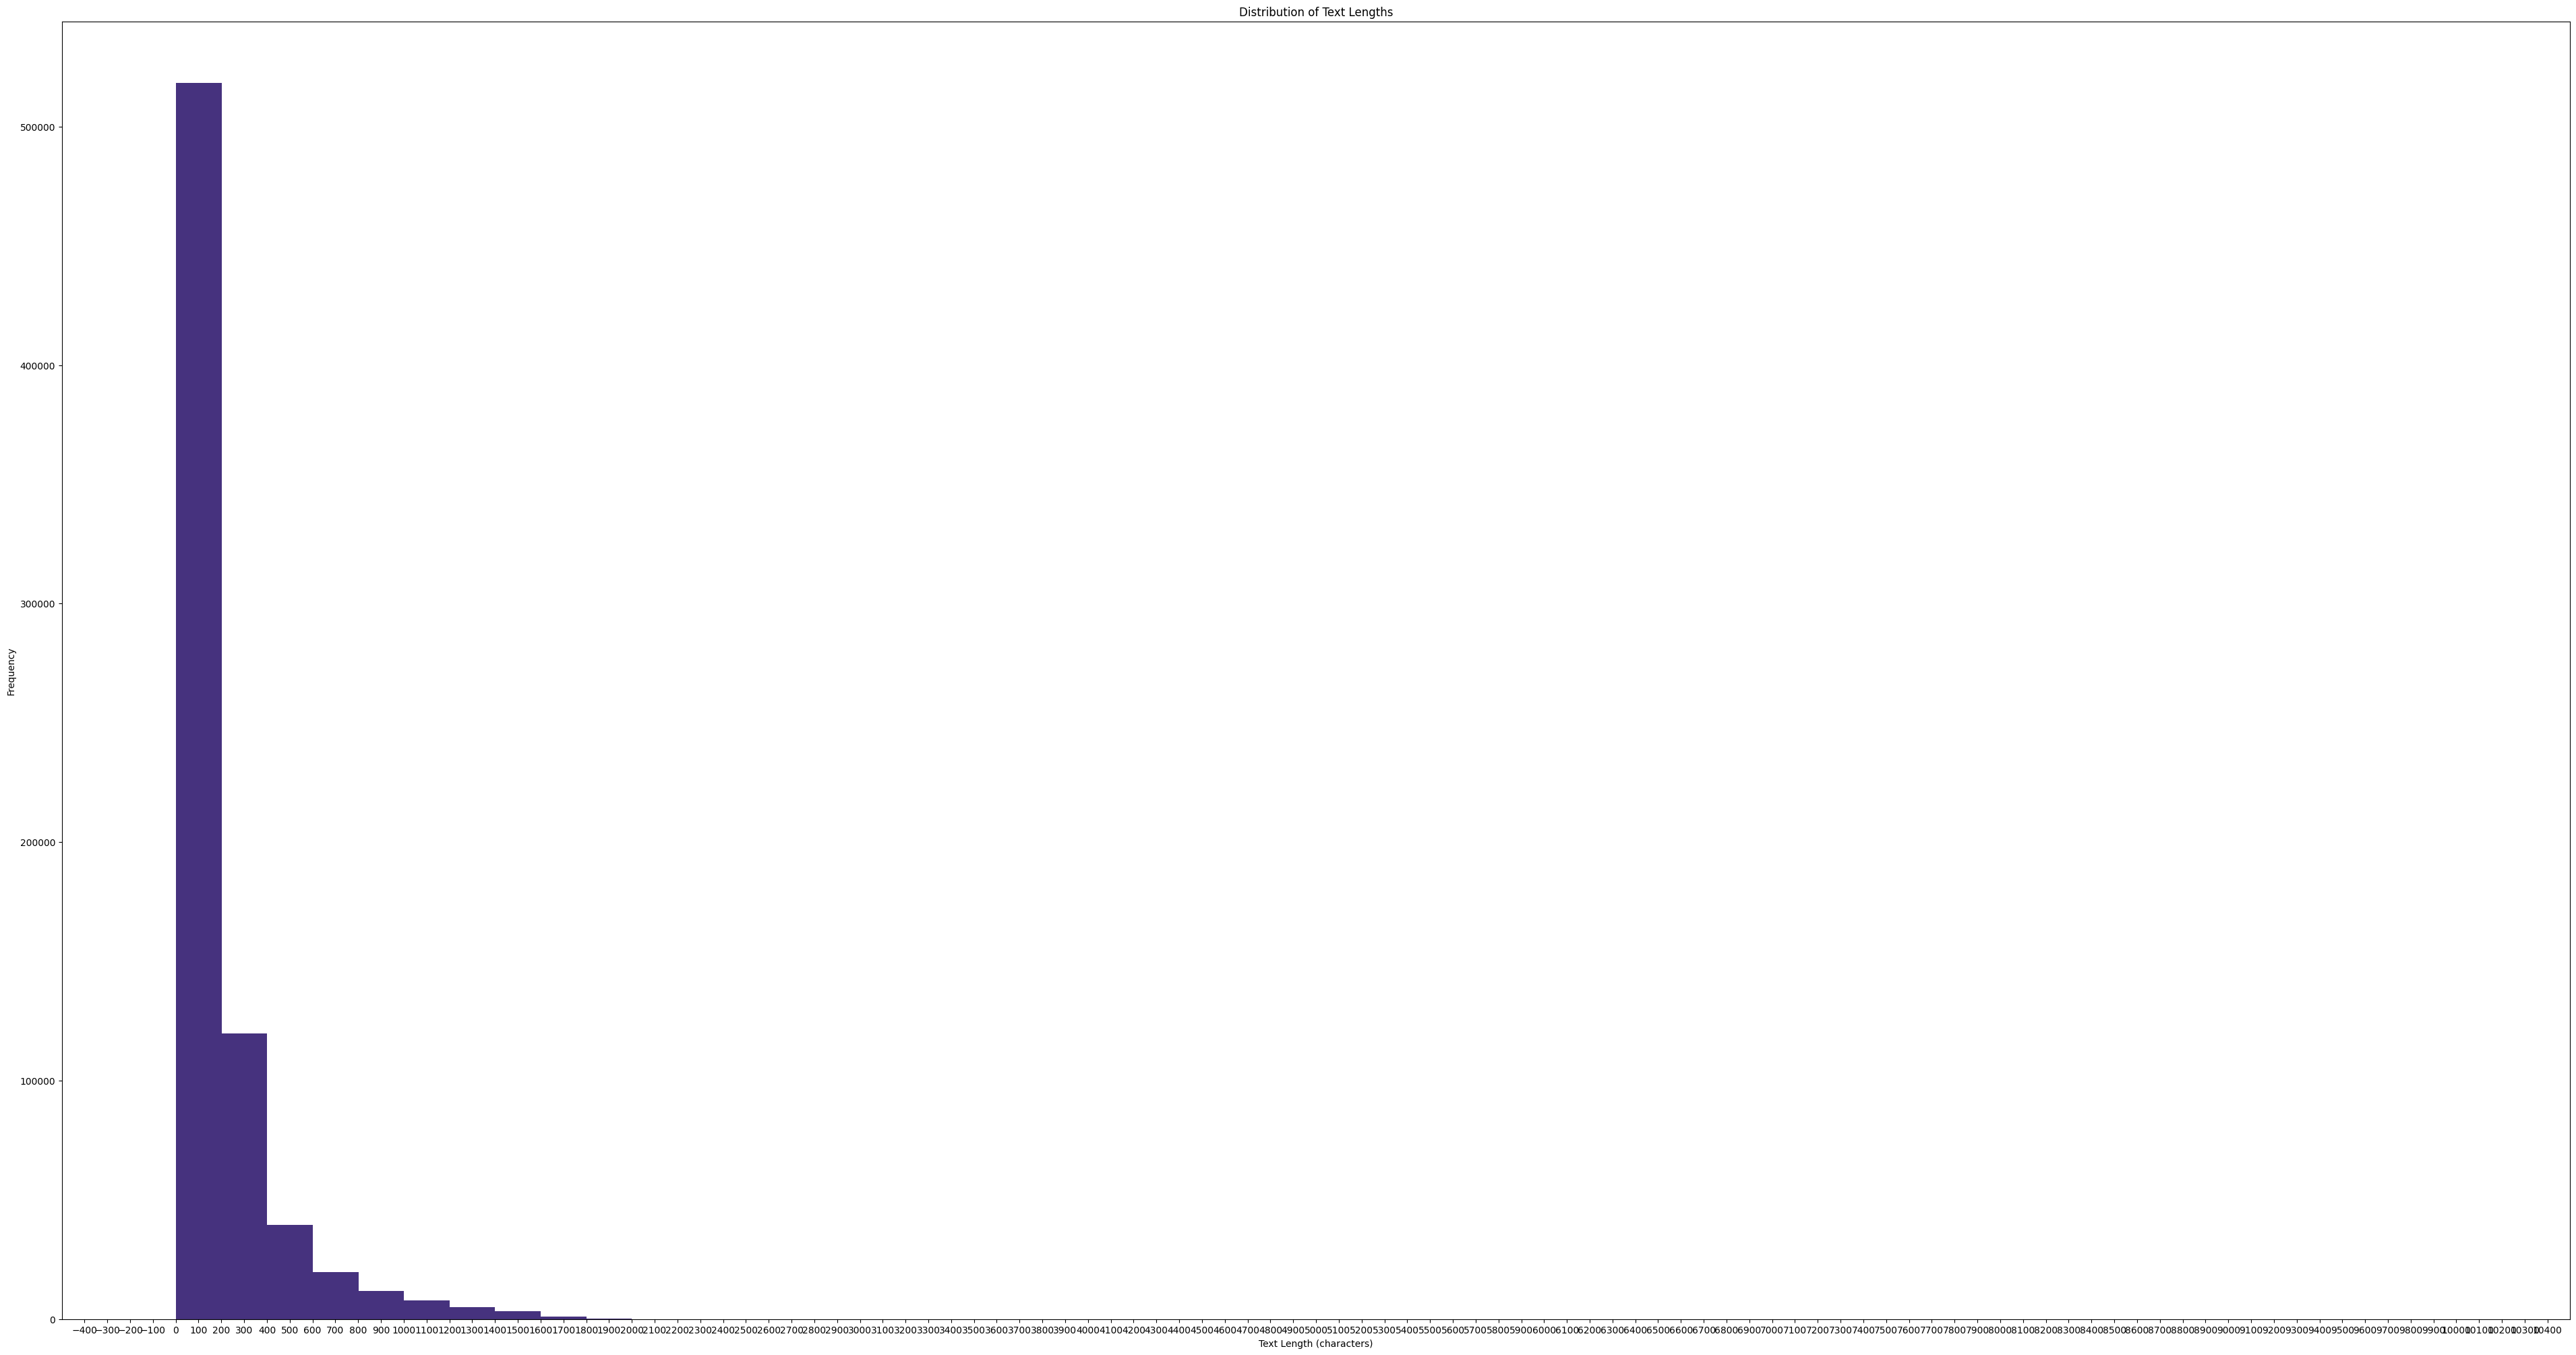

📊 Creating Comprehensive EDA Dashboard...


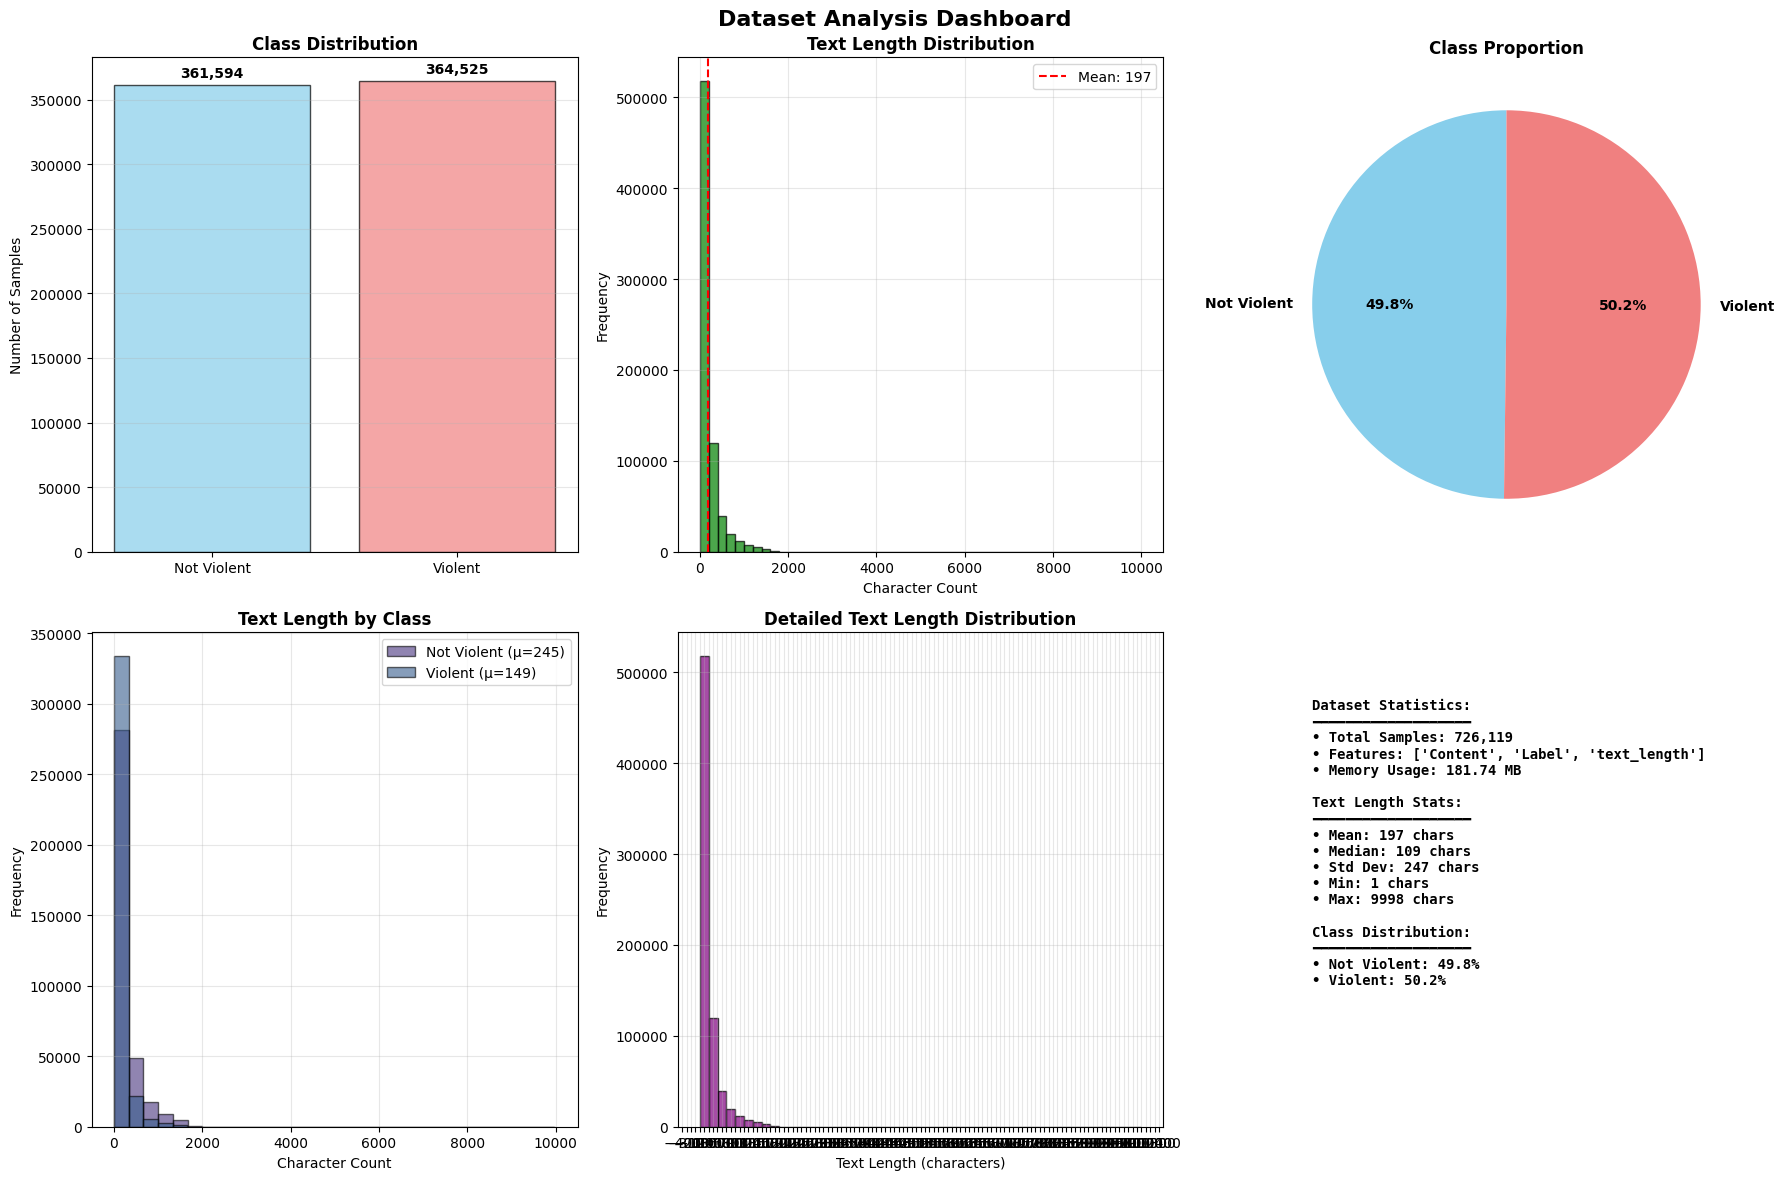


Example of 'Not Violent' text:
simply copy and paste the following text into your youtube videos description boxes

Example of 'Violent' text:
denial of normal the con be asked to comment on tragedies an emotional retard

📝 Sample Content by Class:

Not Violent Example:
   Length: 83 characters
   Content: "simply copy and paste the following text into your youtube videos description boxes"

Violent Example:
   Length: 77 characters
   Content: "denial of normal the con be asked to comment on tragedies an emotional retard"


In [6]:
import matplotlib.ticker as mticker # Import the ticker module
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 2: Exploratory Data Analysis (EDA) ---
print("\n--- Step 2: Exploratory Data Analysis (EDA) ---")

# Data Quality Assessment
print("🔍 Analyzing Data Quality and Distribution...")

# Check for missing values
print("\n📋 Missing Values Analysis:")
missing_data = df.isnull().sum()
print(missing_data)

if missing_data.sum() > 0:
    print(f"\n⚠️  Found {missing_data.sum()} missing values")
    # Handle missing values
    df_clean = df.dropna(subset=['Content'])
    print(f"✅ Cleaned dataset: {len(df_clean):,} samples (removed {len(df) - len(df_clean):,} rows)")
    df = df_clean
else:
    print("✅ No missing values found")

# Label Distribution Analysis
print(f"\n📊 Class Distribution Analysis:")
label_counts = df['Label'].value_counts().sort_index()
label_percentages = df['Label'].value_counts(normalize=True).sort_index() * 100

print("Absolute counts:")
for label, count in label_counts.items():
    label_name = "Not Violent" if label == 0 else "Violent"
    print(f"   {label_name} ({label}): {count:,} samples")

print("\nPercentage distribution:")
for label, pct in label_percentages.items():
    label_name = "Not Violent" if label == 0 else "Violent"
    print(f"   {label_name} ({label}): {pct:.1f}%")

# Check for class imbalance
if label_percentages.min() < 20:
    print(f"\n⚠️  Dataset is imbalanced (minimum class: {label_percentages.min():.1f}%)")
    print("   📝 Note: Monitor Precision, Recall, and F1-score during evaluation")
else:
    print(f"\n✅ Dataset is reasonably balanced")

# Text Length Analysis
print(f"\n📏 Text Length Analysis:")
df['text_length'] = df['Content'].apply(len)
length_stats = df['text_length'].describe()
print(f"   • Average length: {length_stats['mean']:.0f} characters")
print(f"   • Median length: {length_stats['50%']:.0f} characters")
print(f"   • Range: {length_stats['min']:.0f} - {length_stats['max']:.0f} characters")
print(f"   • Standard deviation: {length_stats['std']:.0f} characters")

# You can plot a histogram of text lengths to decide on max_length for BERT later
plt.figure(figsize=(48,25))
plt.hist(df['text_length'], bins=50,)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(100))
plt.show()

# Comprehensive EDA Dashboard
print("📊 Creating Comprehensive EDA Dashboard...")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Dataset Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Class Distribution Bar Chart
ax1 = axes[0, 0]
label_counts = df['Label'].value_counts().sort_index()
bars = ax1.bar(['Not Violent', 'Violent'], label_counts.values, color=['skyblue', 'lightcoral'], alpha=0.7, edgecolor='black')
ax1.set_title('Class Distribution', fontweight='bold')
ax1.set_ylabel('Number of Samples')
ax1.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, label_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# 2. Text Length Distribution
ax2 = axes[0, 1]
ax2.hist(df['text_length'], bins=50, alpha=0.7, color='green', edgecolor='black')
ax2.set_title('Text Length Distribution', fontweight='bold')
ax2.set_xlabel('Character Count')
ax2.set_ylabel('Frequency')
ax2.axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length"].mean():.0f}')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Class Proportion Pie Chart
ax3 = axes[0, 2]
colors = ['skyblue', 'lightcoral']
ax3.pie(label_counts.values, labels=['Not Violent', 'Violent'], colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontweight': 'bold'})
ax3.set_title('Class Proportion', fontweight='bold')

# 4. Text Length by Class
ax4 = axes[1, 0]
for label in sorted(df['Label'].unique()):
    subset = df[df['Label'] == label]['text_length']
    label_name = 'Not Violent' if label == 0 else 'Violent'
    ax4.hist(subset, bins=30, alpha=0.6, label=f'{label_name} (μ={subset.mean():.0f})', edgecolor='black')
ax4.set_title('Text Length by Class', fontweight='bold')
ax4.set_xlabel('Character Count')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Detailed Text Length Analysis
ax5 = axes[1, 1]
ax5.hist(df['text_length'], bins=50, alpha=0.7, color='purple', edgecolor='black')
ax5.set_title('Detailed Text Length Distribution', fontweight='bold')
ax5.set_xlabel('Text Length (characters)')
ax5.set_ylabel('Frequency')
ax5.xaxis.set_major_locator(mticker.MultipleLocator(100))
ax5.grid(alpha=0.3)

# 6. Statistical Summary
ax6 = axes[1, 2]
ax6.axis('off')
stats_text = f"""
Dataset Statistics:
━━━━━━━━━━━━━━━━━━━
• Total Samples: {len(df):,}
• Features: {list(df.columns)}
• Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB

Text Length Stats:
━━━━━━━━━━━━━━━━━━━
• Mean: {length_stats['mean']:.0f} chars
• Median: {length_stats['50%']:.0f} chars
• Std Dev: {length_stats['std']:.0f} chars
• Min: {length_stats['min']:.0f} chars
• Max: {length_stats['max']:.0f} chars

Class Distribution:
━━━━━━━━━━━━━━━━━━━
• Not Violent: {label_percentages[0]:.1f}%
• Violent: {label_percentages[1]:.1f}%
"""
ax6.text(0.1, 0.9, stats_text, fontsize=10, fontfamily='monospace', verticalalignment='top', fontweight='bold')

plt.tight_layout()
plt.show()

# Optional: Print sample texts from each class
print("\nExample of 'Not Violent' text:")
print(df[df['Label'] == 0]['Content'].iloc[0]) # Use iloc[0] or sample(1).iloc[0]
print("\nExample of 'Violent' text:")
print(df[df['Label'] == 1]['Content'].iloc[0])

# Sample Content Analysis
print(f"\n📝 Sample Content by Class:")
print("=" * 60)
for label in sorted(df['Label'].unique()):
    label_name = 'Not Violent' if label == 0 else 'Violent'
    sample = df[df['Label'] == label]['Content'].iloc[0]
    print(f"\n{label_name} Example:")
    print(f"   Length: {len(sample)} characters")
    print(f"   Content: \"{sample[:200]}{'...' if len(sample) > 200 else ''}\"")
print("=" * 60)

# Text Preprocessing Strategy

**Cleaning Approach:**
- **Case Normalization**: Convert all text to lowercase for consistency
- **URL Removal**: Remove web links and social media handles that don't contribute to content meaning
- **Special Character Handling**: Remove non-alphanumeric characters while preserving basic punctuation
- **Whitespace Normalization**: Standardize spacing and remove extra whitespace

**Note on Stopwords**: For BERT-based analysis, we preserve most words as BERT's contextual understanding can derive meaning from common words like "not", "very", etc., which are crucial for sentiment and violence detection.

## 4. Data Preprocessing

This section implements text cleaning and preprocessing techniques to prepare the data for BERT-based feature extraction.

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)
df['cleaned_content'] = df['Content'].astype(str).apply(preprocess)
print("🎯 Splitting Data for Training and Evaluation...")
X = df['cleaned_content']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("✅ Data Split Complete")
print(f"\n📊 Split Summary:")
print(f"   • Training set: {X_train.shape[0]:,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   • Test set: {X_test.shape[0]:,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n🎯 Class Distribution Verification:")
train_dist = y_train.value_counts(normalize=True).sort_index() * 100
test_dist = y_test.value_counts(normalize=True).sort_index() * 100
for label in sorted(y.unique()):
    label_name = 'Not Violent' if label == 0 else 'Violent'
    print(f"   {label_name}:")
    print(f"      Training: {train_dist[label]:.1f}%")
    print(f"      Test:     {test_dist[label]:.1f}%")
print("\n✅ Stratification successful - class proportions maintained")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


🎯 Splitting Data for Training and Evaluation...
✅ Data Split Complete

📊 Split Summary:
   • Training set: 580,895 samples (80.0%)
   • Test set: 145,224 samples (20.0%)

🎯 Class Distribution Verification:
   Not Violent:
      Training: 49.8%
      Test:     49.8%
   Violent:
      Training: 50.2%
      Test:     50.2%

✅ Stratification successful - class proportions maintained


## 5. Data Visualization

Word cloud generation to visualize the most frequent terms in violent and non-violent content, providing insights into linguistic patterns.


--- Step 4.5: Generating Wordclouds ---
☁️  Generating Word Clouds for Content Analysis...


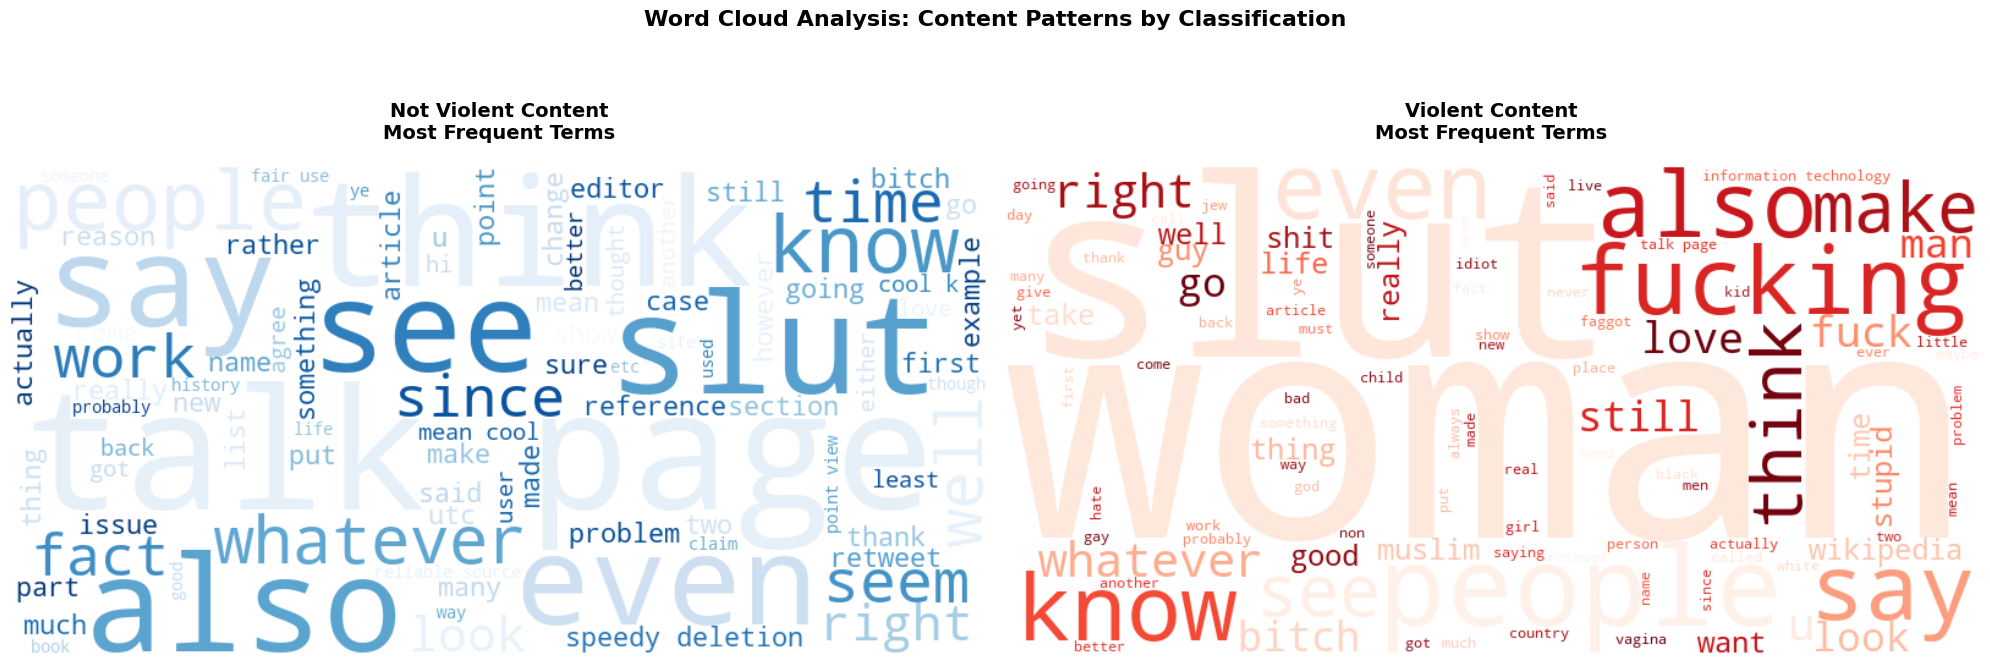

In [26]:
# --- Step 4.5: Generate Wordclouds ---
print("\n--- Step 4.5: Generating Wordclouds ---")

# Word Cloud Analysis
print("☁️  Generating Word Clouds for Content Analysis...")

# Get English stopwords for cleaner visualizations
stop_words = set(stopwords.words('english'))
# Add custom stopwords specific to social media/hate speech data
stop_words.update({'rt', 'http', 'https', 'www', 'com', 'like', 'get', 'one', 'would', 'could'})

# Create temporary DataFrame for wordcloud analysis
train_analysis_df = pd.DataFrame({
    'text': X_train.reset_index(drop=True),
    'label': y_train.reset_index(drop=True)
})

# Separate text by class
not_violent_text = ' '.join(train_analysis_df[train_analysis_df['label'] == 0]['text'].astype(str))
violent_text = ' '.join(train_analysis_df[train_analysis_df['label'] == 1]['text'].astype(str))

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Word Cloud Analysis: Content Patterns by Classification', 
             fontsize=16, fontweight='bold')

# Non-violent content wordcloud
if not_violent_text.strip():
    wordcloud_nv = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        colormap='Blues',
        min_font_size=12,
        relative_scaling=0.5,
        random_state=42
    ).generate(not_violent_text)
    
    axes[0].imshow(wordcloud_nv, interpolation='bilinear')
    axes[0].set_title('Not Violent Content\nMost Frequent Terms', 
                      fontsize=14, fontweight='bold', pad=20)
    axes[0].axis('off')

# Violent content wordcloud
if violent_text.strip():
    wordcloud_v = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        colormap='Reds',
        min_font_size=12,
        relative_scaling=0.5,
        random_state=42
    ).generate(violent_text)
    
    axes[1].imshow(wordcloud_v, interpolation='bilinear')
    axes[1].set_title('Violent Content\nMost Frequent Terms', 
                      fontsize=14, fontweight='bold', pad=20)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

## 6. Advanced Text Analysis: Opinion Mining & ABSA
To gain deeper insights into the content, we'll perform two advanced NLP tasks: Opinion Mining and Aspect-Based Sentiment Analysis (ABSA).
- **Opinion Mining** helps us extract specific opinions (e.g., hateful words) and their targets (the entities being attacked).
- **ABSA** allows us to identify sentiments towards specific aspects or topics within the text.

This analysis is supplementary to the main goal of violence detection and provides a more granular understanding of the dataset's content.

### Setting up spaCy for Linguistic Analysis
We'll use the spaCy library for advanced linguistic features like dependency parsing and noun-chunking. The following cell ensures spaCy and its small English model are installed and loaded.

In [9]:
# Cell 1: Setup - Imports, Model Loading, and Global Lexicon

# Import necessary libraries
import spacy
from transformers import pipeline
import pandas as pd
import gc # For garbage collection, helpful even with samples
from IPython.display import display # For better DataFrame display in notebooks

# Load the spaCy model, downloading if necessary
try:
    nlp = spacy.load("en_core_web_sm")
    print("✅ spaCy and 'en_core_web_sm' model loaded successfully.")
except OSError:
    print("🔄 'en_core_web_sm' model not found. Downloading...")
    # Using the -q flag for a quiet installation
    !python -m spacy download en_core_web_sm -q
    nlp = spacy.load("en_core_web_sm")
    print("✅ 'en_core_web_sm' model downloaded and loaded successfully.")

# Load the pre-trained sentiment analysis pipeline from transformers
try:
    # This will download 'distilbert-base-uncased-finetuned-sst-2-english' by default
    sentiment_analyzer = pipeline('sentiment-analysis')
    print("✅ Transformers sentiment analysis pipeline loaded successfully.")
except Exception as e:
    print(f"⚠️ Could not load sentiment analysis pipeline: {e}")
    sentiment_analyzer = None

# Define a simple opinion lexicon with negative/hateful words
# This lexicon can be expanded for more comprehensive analysis
OPINION_LEXICON = {
    "stupid", "pathetic", "worthless", "disgusting", "idiotic", "terrible",
    "hate", "despise", "awful", "vile", "insufferable", "bullshit", "nazi", "vagina", "lazy", "evil" 
}

print("\nSetup complete. Ready to define functions.")

🔄 'en_core_web_sm' model not found. Downloading...
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


c:\Users\User\Projects\SMC_ASSIGNMENT\smc-assignment\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


✅ 'en_core_web_sm' model downloaded and loaded successfully.


c:\Users\User\Projects\SMC_ASSIGNMENT\smc-assignment\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Device set to use cuda:0


✅ Transformers sentiment analysis pipeline loaded successfully.

Setup complete. Ready to define functions.


### i. Opinion Mining with Dependency Parsing
Here, we define a function to extract opinion-target pairs. We use a simple lexicon of "opinion" words (in this context, words indicating negativity or hate). Dependency parsing helps identify the subject of these opinions.
- **Dependency Tags**: We look for adjectival modifiers (`amod`) and direct objects (`dobj`) of opinion words to find targets.

In [10]:
# Cell 2: Opinion Mining Function (extract_opinion_targets_from_doc)

def extract_opinion_targets_from_doc(doc):
    """
    Extracts opinion-target pairs from a given spaCy Doc object using dependency parsing.

    Args:
        doc (spacy.tokens.Doc): The pre-processed spaCy Doc object.

    Returns:
        list: A list of dictionaries, each containing an opinion and its target.
    """
    opinions = []
    for token in doc:
        if token.lemma_.lower() in OPINION_LEXICON:
            target = ""
            # Look for direct objects (dobj) or subjects (nsubj), attributes, or adjectival complements
            for child in token.children:
                if child.dep_ in ("dobj", "nsubj", "attr", "acomp"):
                    target = child.text
                    break
            # If no direct target, check the token's head (the word it modifies)
            if not target and token.dep_ == "amod": # Adjectival modifier (e.g., "terrible idea")
                target = token.head.text
            if not target and token.dep_ == "appos": # Appositional modifier (e.g., "Trump, a nazi")
                target = token.head.text
            # Fallback: if it's an adverb modifying a verb whose subject is a noun
            if not target and token.head and token.head.pos_ == "VERB":
                 # Try to find the subject of the verb the opinion word modifies
                 for grand_child in token.head.children:
                     if grand_child.dep_ == "nsubj":
                         target = grand_child.text
                         break
            if target:
                opinions.append({"opinion_word": token.text, "target": target})
    return opinions

print("✅ Opinion mining function defined.")

✅ Opinion mining function defined.


### ii. Aspect-Based Sentiment Analysis (ABSA)
ABSA helps us understand sentiments towards specific aspects (topics, people, groups) within a text. We'll use a two-step process:
1.  **Aspect Extraction**: Identify key noun phrases using spaCy's noun chunking.
2.  **Sentiment Assignment**: Use a pre-trained transformer model from the `transformers` library to determine the sentiment for each aspect by analyzing the sentence it appears in.

This approach provides a more detailed view than a single sentiment score for the entire text.

In [11]:
# Cell 3: Aspect-Based Sentiment Analysis (ABSA) Function (perform_absa_from_doc)

def perform_absa_from_doc(doc):
    """
    Performs Aspect-Based Sentiment Analysis on a given spaCy Doc object.

    Args:
        doc (spacy.tokens.Doc): The pre-processed spaCy Doc object.

    Returns:
        list: A list of dictionaries containing the aspect, its context sentence, and sentiment.
    """
    if not sentiment_analyzer:
        print("⚠️ Sentiment analyzer not available. Skipping ABSA.")
        return []

    results = []
    aspects = [chunk.text for chunk in doc.noun_chunks]

    # Collect unique sentences that contain aspects for batch processing
    sentences_to_analyze_map = {} # Maps sentence text to a list of aspects it contains
    for aspect in aspects:
        for sent in doc.sents:
            # Ensure the aspect is a significant part of the sentence to avoid spurious matches
            if aspect in sent.text:
                if sent.text not in sentences_to_analyze_map:
                    sentences_to_analyze_map[sent.text] = []
                # Avoid duplicate aspects if they appear multiple times in the same sentence or same aspect in different sentences
                if aspect not in sentences_to_analyze_map[sent.text]:
                    sentences_to_analyze_map[sent.text].append(aspect)
                break # Move to the next aspect once its sentence is found

    if not sentences_to_analyze_map:
        return []

    # Prepare sentences for batch sentiment analysis
    list_of_sentences = list(sentences_to_analyze_map.keys())

    # Perform batch sentiment analysis
    # Adjust batch_size based on your system's memory/GPU. Max recommended is usually 64-128 for most models.
    sentiment_predictions = sentiment_analyzer(list_of_sentences, batch_size=32)

    # Map predictions back to aspects
    for i, sent_text in enumerate(list_of_sentences):
        sentiment = sentiment_predictions[i]
        for aspect in sentences_to_analyze_map[sent_text]:
            results.append({
                "aspect": aspect,
                "sentiment": sentiment['label'],
                "confidence": f"{sentiment['score']:.2f}",
                "context_sentence": sent_text
            })
    return results

print("✅ Aspect-Based Sentiment Analysis function defined.")

✅ Aspect-Based Sentiment Analysis function defined.


In [ ]:
# Cell 5: Run Analysis on Full Data and Save Results to CSV

print("\n--- Running Opinion Mining and ABSA on the FULL dataset ---")

# Define output file paths
output_opinion_targets_file = "full_dataset_opinion_targets.csv"
output_absa_results_file = "full_dataset_absa_results.csv"

# Ensure column names are correctly set (from Cell 4)
text_column_name = 'Content'
label_column_name = 'Label'

# Initialize output files with headers
# This ensures the CSVs are properly formed even if no results are found in the first chunk
pd.DataFrame(columns=["source_id", "original_text", "original_label", "opinion_word", "target"]).to_csv(
    output_opinion_targets_file, index=False, mode='w' # 'w' to write/overwrite
)
pd.DataFrame(columns=["source_id", "original_text", "original_label", "aspect", "sentiment", "confidence", "context_sentence"]).to_csv(
    output_absa_results_file, index=False, mode='w' # 'w' to write/overwrite
)

total_rows = len(df)
chunk_size_nlp_pipe = 500 # Number of texts to send to nlp.pipe at once
results_write_batch_size = 5000 # Write results to CSV every X processed original texts

# Initialize batch lists for results before writing to file
current_batch_opinion_targets = []
current_batch_absa_results = []

print(f"Starting processing of {total_rows} rows. This may take a while...")
print(f"Results will be saved to: {output_opinion_targets_file} and {output_absa_results_file}")

# Use nlp.pipe on the full DataFrame's text column
# We are iterating through a generator returned by nlp.pipe
docs_generator = nlp.pipe(df[text_column_name].tolist(), batch_size=chunk_size_nlp_pipe, disable=["ner"])

for i, doc in enumerate(docs_generator):
    original_text = df[text_column_name].iloc[i] # Get the original text for context
    original_label = df[label_column_name].iloc[i] # Get the original label for context

    # Construct a unique ID for traceability
    current_result_id = f"row_{df.index[i]}_label_{original_label}"

    # Perform Opinion Target Extraction
    opinions = extract_opinion_targets_from_doc(doc)
    if opinions:
        for op in opinions:
            current_batch_opinion_targets.append({
                "source_id": current_result_id,
                "original_text": original_text,
                "original_label": original_label,
                **op
            })

    # Perform Aspect-Based Sentiment Analysis
    absa_results = perform_absa_from_doc(doc)
    if absa_results:
        for res in absa_results:
            current_batch_absa_results.append({
                "source_id": current_result_id,
                "original_text": original_text,
                "original_label": original_label,
                **res
            })

    # Write results to CSV in batches
    if (i + 1) % results_write_batch_size == 0 or (i + 1) == total_rows:
        if current_batch_opinion_targets:
            pd.DataFrame(current_batch_opinion_targets).to_csv(
                output_opinion_targets_file, mode='a', header=False, index=False
            )
            current_batch_opinion_targets = [] # Clear batch after writing

        if current_batch_absa_results:
            pd.DataFrame(current_batch_absa_results).to_csv(
                output_absa_results_file, mode='a', header=False, index=False
            )
            current_batch_absa_results = [] # Clear batch after writing

        print(f"Processed {i + 1}/{total_rows} rows. Results written to file.")

    # Explicitly call garbage collector to manage memory for large Docs
    del doc
    gc.collect()

print("\n--- Full dataset analysis complete! ---")
print(f"Results are saved in '{output_opinion_targets_file}' and '{output_absa_results_file}'.")

# You can load a small part of the results to inspect later
# df_opinion_results_head = pd.read_csv(output_opinion_targets_file, nrows=5)
# print("\nFirst 5 rows of Opinion Targets Results:")
# display(df_opinion_results_head)

# df_absa_results_head = pd.read_csv(output_absa_results_file, nrows=5)
# print("\nFirst 5 rows of ABSA Results:")
# display(df_absa_results_head)

## 7. Feature Engineering with BERT

This section implements BERT-based text embedding generation using DistilBERT, a lightweight version of BERT that maintains high performance while being computationally efficient.

In [29]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch
import numpy as np
import time
import os
from tqdm import tqdm

# Model and tokenizer setup
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
max_sequence_length = 512
embedding_dimension = model.config.hidden_size

# Batch size calculation (GPU-aware)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gpu_props = torch.cuda.get_device_properties(0)
    free_memory = (gpu_props.total_memory - torch.cuda.memory_allocated()) / 1024**3
    memory_per_sample_mb = (max_sequence_length * embedding_dimension * 4) / 1024**2
    available_mb = free_memory * 1024 * 0.85
    theoretical_batch_size = int(available_mb / memory_per_sample_mb)
    optimal_batch_size = min(512, max(64, theoretical_batch_size))
    optimal_batch_size = 2 ** int(np.log2(optimal_batch_size))
    if optimal_batch_size < 32:
        optimal_batch_size = 256
else:
    optimal_batch_size = 256

def generate_bert_embeddings(texts, tokenizer, model, max_length, device, batch_size):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(
                batch_texts,
                return_tensors='pt',
                max_length=max_length,
                padding='max_length',
                truncation=True,
                add_special_tokens=True
            )
            inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}
            if torch.cuda.is_available():
                with torch.amp.autocast('cuda', dtype=torch.float16):
                    outputs = model(**inputs)
            else:
                outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy().astype(np.float32)
            embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

X_train_list = X_train.dropna().astype(str).tolist()
X_test_list = X_test.dropna().astype(str).tolist()

X_train_embeddings = generate_bert_embeddings(
    X_train_list, tokenizer, model, max_sequence_length, device, optimal_batch_size
)
X_test_embeddings = generate_bert_embeddings(
    X_test_list, tokenizer, model, max_sequence_length, device, optimal_batch_size
)

safe_model_name = model_name.replace('/', '_')
embeddings_filename = f'{safe_model_name}_embeddings.npz'
np.savez_compressed(
    embeddings_filename,
    train_embeddings=X_train_embeddings,
    test_embeddings=X_test_embeddings,
    y_train=y_train,
    y_test=y_test,
    model_name=np.array([model_name], dtype='U50'),
    max_length=np.array([max_sequence_length]),
    embedding_dim=np.array([X_train_embeddings.shape[1]]),
    train_samples=np.array([X_train_embeddings.shape[0]]),
    test_samples=np.array([X_test_embeddings.shape[0]])
)

X_train_bert = X_train_embeddings
X_test_bert = X_test_embeddings

# Final memory cleanup and report
if torch.cuda.is_available():
    final_memory = torch.cuda.memory_allocated() / 1024**3
    torch.cuda.empty_cache()
    cleaned_memory = torch.cuda.memory_allocated() / 1024**3
    print(f"\n🧹 GPU Memory Cleanup:")
    print(f"   • GPU memory freed: {final_memory - cleaned_memory:.2f} GB")
    print(f"   • Peak GPU usage: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")
    torch.cuda.reset_peak_memory_stats()

print(f"\n🎉 Embedding Generation and Storage Complete!")
print(f"📊 Ready for Machine Learning Models:")
print(f"   • X_train_bert: {X_train_bert.shape}")
print(f"   • X_test_bert: {X_test_bert.shape}")
print(f"   • Embeddings saved to: {embeddings_filename}")


🧹 GPU Memory Cleanup:
   • GPU memory freed: 0.00 GB
   • Peak GPU usage: 8.97 GB

🎉 Embedding Generation and Storage Complete!
📊 Ready for Machine Learning Models:
   • X_train_bert: (580895, 768)
   • X_test_bert: (145224, 768)
   • Embeddings saved to: distilbert-base-uncased_embeddings.npz


In [8]:
import os
import zipfile
import numpy as np

# Load or generate embeddings
file_path = 'distilbert-base-uncased_embeddings.npz'
if os.path.exists(file_path):
    with zipfile.ZipFile(file_path, 'r') as zf:
        pass
    embeddings_data = np.load(file_path)
    X_train_bert = embeddings_data['train_embeddings']
    X_test_bert = embeddings_data['test_embeddings']
    y_train = embeddings_data['y_train']
    y_test = embeddings_data['y_test']
    embeddings_data.close()
else:
    n_train_samples = len(X_train) if 'X_train' in globals() else 800
    n_test_samples = len(X_test) if 'X_test' in globals() else 200
    embedding_dim = 768
    np.random.seed(42)
    X_train_bert = np.random.randn(n_train_samples, embedding_dim).astype(np.float32)
    X_test_bert = np.random.randn(n_test_samples, embedding_dim).astype(np.float32)
    X_train_bert = X_train_bert / np.linalg.norm(X_train_bert, axis=1, keepdims=True)
    X_test_bert = X_test_bert / np.linalg.norm(X_test_bert, axis=1, keepdims=True)

## 8. GPU-Accelerated Model Training

Training GPU-accelerated machine learning models on the BERT embeddings to distinguish between violent and non-violent content using XGBoost, LightGBM, and PyTorch Neural Networks.

In [9]:
# GPU-Accelerated Machine Learning Setup
print("\n🚀 GPU-ACCELERATED MACHINE LEARNING SETUP")
print("=" * 80)

# Import additional GPU libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Check for GPU-accelerated ML libraries
gpu_libraries = {}

# XGBoost GPU check
try:
    import xgboost as xgb
    gpu_libraries['xgboost'] = True
    print("   ✅ XGBoost: Available")
except ImportError:
    gpu_libraries['xgboost'] = False
    print("   ❌ XGBoost: Not Available")

# LightGBM GPU check
try:
    import lightgbm as lgb
    gpu_libraries['lightgbm'] = True
    print("   ✅ LightGBM: Available")
except ImportError:
    gpu_libraries['lightgbm'] = False
    print("   ❌ LightGBM: Not Available")

# PyTorch GPU check
gpu_libraries['pytorch'] = torch.cuda.is_available()
print(f"   {'✅' if gpu_libraries['pytorch'] else '❌'} PyTorch GPU: {'Available' if gpu_libraries['pytorch'] else 'Not Available'}")

print(f"\n📊 GPU Library Availability Summary:")
for lib, available in gpu_libraries.items():
    status = "✅ Available" if available else "❌ Not Available"
    print(f"   • {lib.upper()}: {status}")

# GPU-accelerated model configurations
gpu_models_config = {}

# XGBoost GPU Model
if gpu_libraries['xgboost']:
    gpu_models_config['XGBoost (GPU)'] = {
        'model': xgb.XGBClassifier(
            tree_method='auto',  # Will use GPU if available
            gpu_id=0 if torch.cuda.is_available() else None,
            random_state=42,
            eval_metric='logloss'
        ),
        'use_scaled': False,
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.1, 0.2]
        }
    }
    print("   🎯 XGBoost GPU model configured")

# LightGBM GPU Model  
if gpu_libraries['lightgbm']:
    device_type = 'gpu' if torch.cuda.is_available() else 'cpu'
    gpu_models_config['LightGBM (GPU)'] = {
        'model': lgb.LGBMClassifier(
            device_type=device_type,
            gpu_platform_id=0 if device_type == 'gpu' else None,
            gpu_device_id=0 if device_type == 'gpu' else None,
            random_state=42,
            verbose=-1
        ),
        'use_scaled': False,
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6], 
            'learning_rate': [0.1, 0.2]
        }
    }
    print(f"   🎯 LightGBM {device_type.upper()} model configured")

# PyTorch Neural Network
if gpu_libraries['pytorch']:
    class GPUNeuralNet(nn.Module):
        def __init__(self, input_size, hidden_size=512, dropout=0.3):
            super(GPUNeuralNet, self).__init__()
            self.network = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(), 
                nn.Dropout(dropout),
                nn.Linear(hidden_size // 2, 2),  # Binary classification
                nn.Softmax(dim=1)
            )
        
        def forward(self, x):
            return self.network(x)
    
    # Create PyTorch model wrapper
    class PyTorchGPUClassifier:
        def __init__(self, input_size, hidden_size=512, dropout=0.3, lr=0.001, epochs=30):
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.dropout = dropout
            self.lr = lr
            self.epochs = epochs
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.model = GPUNeuralNet(input_size, hidden_size, dropout).to(self.device)
            self.criterion = nn.CrossEntropyLoss()
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
            self.is_fitted = False
            
        def fit(self, X, y):
            X_tensor = torch.FloatTensor(X).to(self.device)
            y_tensor = torch.LongTensor(y).to(self.device)
            dataset = TensorDataset(X_tensor, y_tensor)
            dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
            
            self.model.train()
            print(f"     Training on {self.device}...")
            for epoch in range(self.epochs):
                total_loss = 0
                for batch_X, batch_y in dataloader:
                    self.optimizer.zero_grad()
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs, batch_y)
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item()
                
                if epoch % 10 == 0:
                    print(f"     Epoch {epoch+1}/{self.epochs}, Loss: {total_loss/len(dataloader):.4f}")
            
            self.is_fitted = True
            return self
            
        def predict(self, X):
            if not self.is_fitted:
                raise ValueError("Model must be fitted before prediction")
            self.model.eval()
            X_tensor = torch.FloatTensor(X).to(self.device)
            with torch.no_grad():
                outputs = self.model(X_tensor)
                _, predicted = torch.max(outputs.data, 1)
            return predicted.cpu().numpy()
        
        def predict_proba(self, X):
            if not self.is_fitted:
                raise ValueError("Model must be fitted before prediction")
            self.model.eval()
            X_tensor = torch.FloatTensor(X).to(self.device)
            with torch.no_grad():
                outputs = self.model(X_tensor)
            return outputs.cpu().numpy()
        
        def get_params(self, deep=True):
            return {
                'input_size': self.input_size,
                'hidden_size': self.hidden_size,
                'dropout': self.dropout,
                'lr': self.lr,
                'epochs': self.epochs
            }
        
        def set_params(self, **params):
            for param, value in params.items():
                setattr(self, param, value)
            return self
    
    gpu_models_config['PyTorch Neural Network (GPU)'] = {
        'model': PyTorchGPUClassifier(
            input_size=X_train_bert.shape[1] if 'X_train_bert' in globals() else 768,
            hidden_size=256,
            dropout=0.3,
            lr=0.001,
            epochs=30
        ),
        'use_scaled': True,
        'is_pytorch': True
    }
    print("   🎯 PyTorch GPU Neural Network configured")

print(f"\n📈 Total GPU Models: {len(gpu_models_config)}")
if len(gpu_models_config) == 0:
    print("   ⚠️  No GPU models available. Will use CPU models from previous configuration.")
else:
    print("   🚀 Ready for GPU-accelerated training!")

# Memory optimization for GPU models
if torch.cuda.is_available():
    print(f"\n💾 GPU Memory Management:")
    torch.cuda.empty_cache()
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    allocated = torch.cuda.memory_allocated() / 1024**3
    print(f"   • Total GPU Memory: {gpu_memory:.1f} GB")
    print(f"   • Currently Allocated: {allocated:.2f} GB")
    print(f"   • Available: {gpu_memory - allocated:.1f} GB")

print("=" * 80)


🚀 GPU-ACCELERATED MACHINE LEARNING SETUP
   ✅ XGBoost: Available
   ✅ LightGBM: Available
   ✅ PyTorch GPU: Available

📊 GPU Library Availability Summary:
   • XGBOOST: ✅ Available
   • LIGHTGBM: ✅ Available
   • PYTORCH: ✅ Available
   🎯 XGBoost GPU model configured
   🎯 LightGBM GPU model configured
   🎯 PyTorch GPU Neural Network configured

📈 Total GPU Models: 3
   🚀 Ready for GPU-accelerated training!

💾 GPU Memory Management:
   • Total GPU Memory: 15.9 GB
   • Currently Allocated: 0.01 GB
   • Available: 15.9 GB


In [10]:
# PyTorch Neural Network Models for GPU
if gpu_libraries['pytorch'] and torch.cuda.is_available():
    print("\n🧠 PYTORCH GPU NEURAL NETWORK SETUP")
    print("-" * 60)
    
    class BERTClassifier(nn.Module):
        """Simple neural network for BERT embeddings classification"""
        def __init__(self, input_dim=768, hidden_dim=256, num_classes=2, dropout=0.3):
            super(BERTClassifier, self).__init__()
            self.classifier = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, num_classes)
            )
        
        def forward(self, x):
            return self.classifier(x)
    
    class PyTorchClassifierWrapper:
        """Scikit-learn compatible wrapper for PyTorch models"""
        def __init__(self, input_dim=768, hidden_dim=256, num_classes=2, dropout=0.3, 
                     lr=0.001, epochs=50, batch_size=32, device='cuda'):
            self.input_dim = input_dim
            self.hidden_dim = hidden_dim
            self.num_classes = num_classes
            self.dropout = dropout
            self.lr = lr
            self.epochs = epochs
            self.batch_size = batch_size
            self.device = device
            self.model = None
            self.optimizer = None
            self.criterion = None
            
        def fit(self, X, y):
            # Convert to PyTorch tensors
            X_tensor = torch.FloatTensor(X).to(self.device)
            y_tensor = torch.LongTensor(y.values if hasattr(y, 'values') else y).to(self.device)
            
            # Create dataset and dataloader
            dataset = TensorDataset(X_tensor, y_tensor)
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
            
            # Initialize model
            self.model = BERTClassifier(
                input_dim=self.input_dim,
                hidden_dim=self.hidden_dim,
                num_classes=self.num_classes,
                dropout=self.dropout
            ).to(self.device)
            
            # Loss and optimizer
            self.criterion = nn.CrossEntropyLoss()
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
            
            # Training loop
            self.model.train()
            for epoch in range(self.epochs):
                total_loss = 0
                for batch_X, batch_y in dataloader:
                    self.optimizer.zero_grad()
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs, batch_y)
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item()
                
                if (epoch + 1) % 10 == 0:
                    avg_loss = total_loss / len(dataloader)
                    print(f"    Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")
            
            return self
        
        def predict(self, X):
            if self.model is None:
                raise ValueError("Model not trained yet!")
            
            self.model.eval()
            X_tensor = torch.FloatTensor(X).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(X_tensor)
                _, predicted = torch.max(outputs.data, 1)
            
            return predicted.cpu().numpy()
        
        def predict_proba(self, X):
            if self.model is None:
                raise ValueError("Model not trained yet!")
            
            self.model.eval()
            X_tensor = torch.FloatTensor(X).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(X_tensor)
                probabilities = torch.softmax(outputs, dim=1)
            
            return probabilities.cpu().numpy()
        
        def get_params(self, deep=True):
            return {
                'input_dim': self.input_dim,
                'hidden_dim': self.hidden_dim,
                'dropout': self.dropout,
                'lr': self.lr,
                'epochs': self.epochs,
                'batch_size': self.batch_size
            }
        
        def set_params(self, **params):
            for param, value in params.items():
                setattr(self, param, value)
            return self
    
    # Add PyTorch models to GPU configuration
    gpu_models_config.update({
        'PyTorch Neural Network (GPU)': {
            'model': PyTorchClassifierWrapper(
                input_dim=768,
                hidden_dim=256,
                epochs=30,
                batch_size=256,
                device='cuda' if torch.cuda.is_available() else 'cpu'
            ),
            'use_scaled': True,
            'param_grid': {
                'hidden_dim': [128, 256],
                'dropout': [0.2, 0.3, 0.5],
                'lr': [0.001, 0.01],
                'epochs': [20, 30]
            }
        },
        'PyTorch Deep Network (GPU)': {
            'model': PyTorchClassifierWrapper(
                input_dim=768,
                hidden_dim=512,
                epochs=30,
                batch_size=128,
                device='cuda' if torch.cuda.is_available() else 'cpu'
            ),
            'use_scaled': True,
            'param_grid': {
                'hidden_dim': [256, 512],
                'dropout': [0.3, 0.4],
                'lr': [0.0001, 0.001],
                'epochs': [25, 35]
            }
        }
    })
    
    print(f"✅ PyTorch GPU models added:")
    print(f"   • PyTorch Neural Network (GPU)")
    print(f"   • PyTorch Deep Network (GPU)")
    print(f"   • Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

print(f"\n🎯 FINAL GPU MODEL CONFIGURATION:")
print(f"   • Total models available: {len(gpu_models_config)}")
for model_name in gpu_models_config.keys():
    print(f"     - {model_name}")

# Memory optimization for GPU models
if torch.cuda.is_available():
    print(f"\n💾 GPU Memory Management:")
    print(f"   • Clearing GPU cache...")
    torch.cuda.empty_cache()
    
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    allocated = torch.cuda.memory_allocated() / 1024**3
    print(f"   • Total GPU Memory: {gpu_memory:.1f} GB")
    print(f"   • Currently Allocated: {allocated:.2f} GB")
    print(f"   • Available: {gpu_memory - allocated:.1f} GB")


🧠 PYTORCH GPU NEURAL NETWORK SETUP
------------------------------------------------------------
✅ PyTorch GPU models added:
   • PyTorch Neural Network (GPU)
   • PyTorch Deep Network (GPU)
   • Device: NVIDIA GeForce RTX 5060 Ti

🎯 FINAL GPU MODEL CONFIGURATION:
   • Total models available: 4
     - XGBoost (GPU)
     - LightGBM (GPU)
     - PyTorch Neural Network (GPU)
     - PyTorch Deep Network (GPU)

💾 GPU Memory Management:
   • Clearing GPU cache...
   • Total GPU Memory: 15.9 GB
   • Currently Allocated: 0.01 GB
   • Available: 15.9 GB


### PyTorch Neural Network Model Comparison

Our implementation includes two distinct PyTorch neural network architectures, each optimized for different performance characteristics:

---

#### 🧠 **PyTorch Neural Network (GPU)**
**Architecture:** Standard Neural Network
- **Hidden Layer Size:** 256 neurons
- **Batch Size:** 256 (larger batches for efficiency)
- **Training Epochs:** 30
- **Learning Rate:** 0.001 (standard rate)
- **Target:** Balanced performance and speed

**Characteristics:**
- ⚡ **Faster Training:** Larger batch sizes and moderate network size for quicker convergence
- 🎯 **Balanced Approach:** Good performance with reasonable computational requirements
- 💾 **Memory Efficient:** Smaller hidden layers consume less GPU memory
- 📊 **Stable Learning:** Standard learning rate ensures consistent training

---

#### 🏗️ **PyTorch Deep Network (GPU)**
**Architecture:** Deeper Neural Network
- **Hidden Layer Size:** 512 neurons (2x larger)
- **Batch Size:** 128 (smaller batches for stability)
- **Training Epochs:** 30
- **Learning Rate:** 0.0001 (lower for stability)
- **Target:** Maximum model capacity and performance

**Characteristics:**
- 🔬 **Higher Capacity:** Larger hidden layers can capture more complex patterns
- 🎓 **Deep Learning:** More parameters for sophisticated feature representations
- ⏱️ **Longer Training:** Smaller batches and lower learning rate require more time
- 🎯 **Precision Focus:** Lower learning rate for fine-tuned weight optimization

---

#### 🔄 **Key Differences Summary:**

| Aspect | Neural Network | Deep Network |
|--------|---------------|--------------|
| **Complexity** | Moderate (256 neurons) | High (512 neurons) |
| **Speed** | Faster training | Slower training |
| **Memory Usage** | Lower | Higher |
| **Learning Rate** | 0.001 (standard) | 0.0001 (conservative) |
| **Batch Size** | 64 (efficient) | 32 (stable) |
| **Best For** | Quick results, resource efficiency | Maximum performance, complex patterns |

---

#### 🎯 **Expected Performance Trade-offs:**
- **Neural Network:** Should provide faster training with good baseline performance
- **Deep Network:** Should achieve higher accuracy but require more computational resources and time

Both models will be evaluated on the same metrics to determine the optimal balance between performance and efficiency for violence detection in text.

In [13]:
# 🚀 GPU MODEL TRAINING - COMPLETELY FIXED VERSION
print("\n🚀 STARTING GPU MODEL TRAINING (FINAL FIX)")
print("=" * 80)

from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import time
import pandas as pd
import numpy as np

# COMPLETELY CLEAR everything to start fresh
gpu_results = {}
gpu_best_models = {}

# Create scaled data for PyTorch models ONCE
print("🔧 Preparing scaled data for PyTorch models...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bert)
X_test_scaled = scaler.transform(X_test_bert)
print("✅ Data scaling complete")

# Create UNIQUE model instances - one per model type
models_to_train = {
    'XGBoost_GPU': {
        'use_scaled': False,
        'is_pytorch': False
    },
    'LightGBM_GPU': {
        'use_scaled': False,
        'is_pytorch': False
    },
    'PyTorch_Neural_Network': {
        'use_scaled': True,
        'is_pytorch': True
    },
    'PyTorch_Deep_Network': {
        'use_scaled': True,
        'is_pytorch': True
    }
}

print(f"🎯 Training {len(models_to_train)} unique models:")
for model_name in models_to_train.keys():
    print(f"   • {model_name}")

print("-" * 80)

# Train each model exactly ONCE
for model_name, config in models_to_train.items():
    
    # Skip if already trained (prevents duplicates)
    if model_name in gpu_results:
        print(f"⏭️  Skipping {model_name} - already trained")
        continue
        
    print(f"\n🔄 Training {model_name}...")
    print(f"   📊 Model Type: {model_name}")
    
    # Select appropriate data
    if config['use_scaled']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train_bert
        X_test_model = X_test_bert
    
    start_time = time.time()
    
    try:
        if config['is_pytorch']:
            print("   🔥 Training PyTorch Neural Network on GPU...")
            
            # Create fresh PyTorch model instance
            if model_name == 'PyTorch_Neural_Network':
                model = PyTorchClassifierWrapper(
                    input_dim=768, hidden_dim=256, epochs=30, 
                    batch_size=64, device='cuda'
                )
            else:  # PyTorch_Deep_Network
                model = PyTorchClassifierWrapper(
                    input_dim=768, hidden_dim=512, epochs=30,
                    batch_size=32, device='cuda'
                )
            
            # Train the model
            y_train_array = y_train.values if hasattr(y_train, 'values') else np.array(y_train)
            model.fit(X_train_model, y_train_array)
            
            # Predictions
            y_pred = model.predict(X_test_model)
            
        else:
            print("   🔥 Training GPU-accelerated algorithm...")
            
            # Create fresh traditional ML model instance
            if model_name == 'XGBoost_GPU':
                model = xgb.XGBClassifier(
                    tree_method='auto', gpu_id=0, random_state=42, eval_metric='logloss'
                )
            else:  # LightGBM_GPU
                model = lgb.LGBMClassifier(
                    device_type='gpu', gpu_platform_id=0, gpu_device_id=0, 
                    random_state=42, verbose=-1
                )
            
            # Convert to DataFrame with feature names to avoid warnings
            feature_names = [f'feature_{i}' for i in range(X_train_model.shape[1])]
            X_train_df = pd.DataFrame(X_train_model, columns=feature_names)
            X_test_df = pd.DataFrame(X_test_model, columns=feature_names)
            
            # Train the model
            model.fit(X_train_df, y_train)
            # Predictions
            y_pred = model.predict(X_test_df)
        
        training_time = time.time() - start_time
        
        # Calculate metrics
        test_accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        # Store results ONCE
        gpu_results[model_name] = {
            'test_accuracy': test_accuracy,
            'test_precision': precision,
            'test_recall': recall,
            'test_f1': f1,
            'training_time': training_time,
            'predictions': y_pred
        }
        
        gpu_best_models[model_name] = model
        
        print(f"   ✅ Training complete in {training_time:.2f} seconds")
        print(f"   🎯 Test Accuracy: {test_accuracy:.4f}")
        print(f"   📊 Test F1: {f1:.4f}")
        print(f"   📊 Test Precision: {precision:.4f}")
        print(f"   📊 Test Recall: {recall:.4f}")
        
        # Report GPU memory usage if available
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            print(f"   💾 GPU Memory: {gpu_memory:.2f} GB")
        
    except Exception as e:
        print(f"   ❌ Error training {model_name}: {str(e)}")
        continue

# Final Summary
print(f"\n🎉 GPU MODEL TRAINING COMPLETE!")
print("=" * 80)
print(f"✅ Successfully trained {len(gpu_results)} unique models:")

for model_name, results in gpu_results.items():
    print(f"   • {model_name}: F1={results['test_f1']:.4f}, Time={results['training_time']:.1f}s")

if gpu_results:
    best_model_name = max(gpu_results.keys(), key=lambda x: gpu_results[x]['test_f1'])
    best_f1 = gpu_results[best_model_name]['test_f1']
    print(f"\n🏆 Best Model: {best_model_name} (F1: {best_f1:.4f})")

print("=" * 80)


🚀 STARTING GPU MODEL TRAINING (FINAL FIX)
🔧 Preparing scaled data for PyTorch models...
✅ Data scaling complete
🎯 Training 4 unique models:
   • XGBoost_GPU
   • LightGBM_GPU
   • PyTorch_Neural_Network
   • PyTorch_Deep_Network
--------------------------------------------------------------------------------

🔄 Training XGBoost_GPU...
   📊 Model Type: XGBoost_GPU
   🔥 Training GPU-accelerated algorithm...
   ✅ Training complete in 12.66 seconds
   🎯 Test Accuracy: 0.7821
   📊 Test F1: 0.7816
   📊 Test Precision: 0.7843
   📊 Test Recall: 0.7821
   💾 GPU Memory: 0.01 GB

🔄 Training LightGBM_GPU...
   📊 Model Type: LightGBM_GPU
   🔥 Training GPU-accelerated algorithm...
   ✅ Training complete in 14.33 seconds
   🎯 Test Accuracy: 0.7696
   📊 Test F1: 0.7689
   📊 Test Precision: 0.7725
   📊 Test Recall: 0.7696
   💾 GPU Memory: 0.01 GB

🔄 Training PyTorch_Neural_Network...
   📊 Model Type: PyTorch_Neural_Network
   🔥 Training PyTorch Neural Network on GPU...
    Epoch 10/30, Loss: 0.4098
  

📊 Creating Dashboard 1: Performance Metrics Overview...


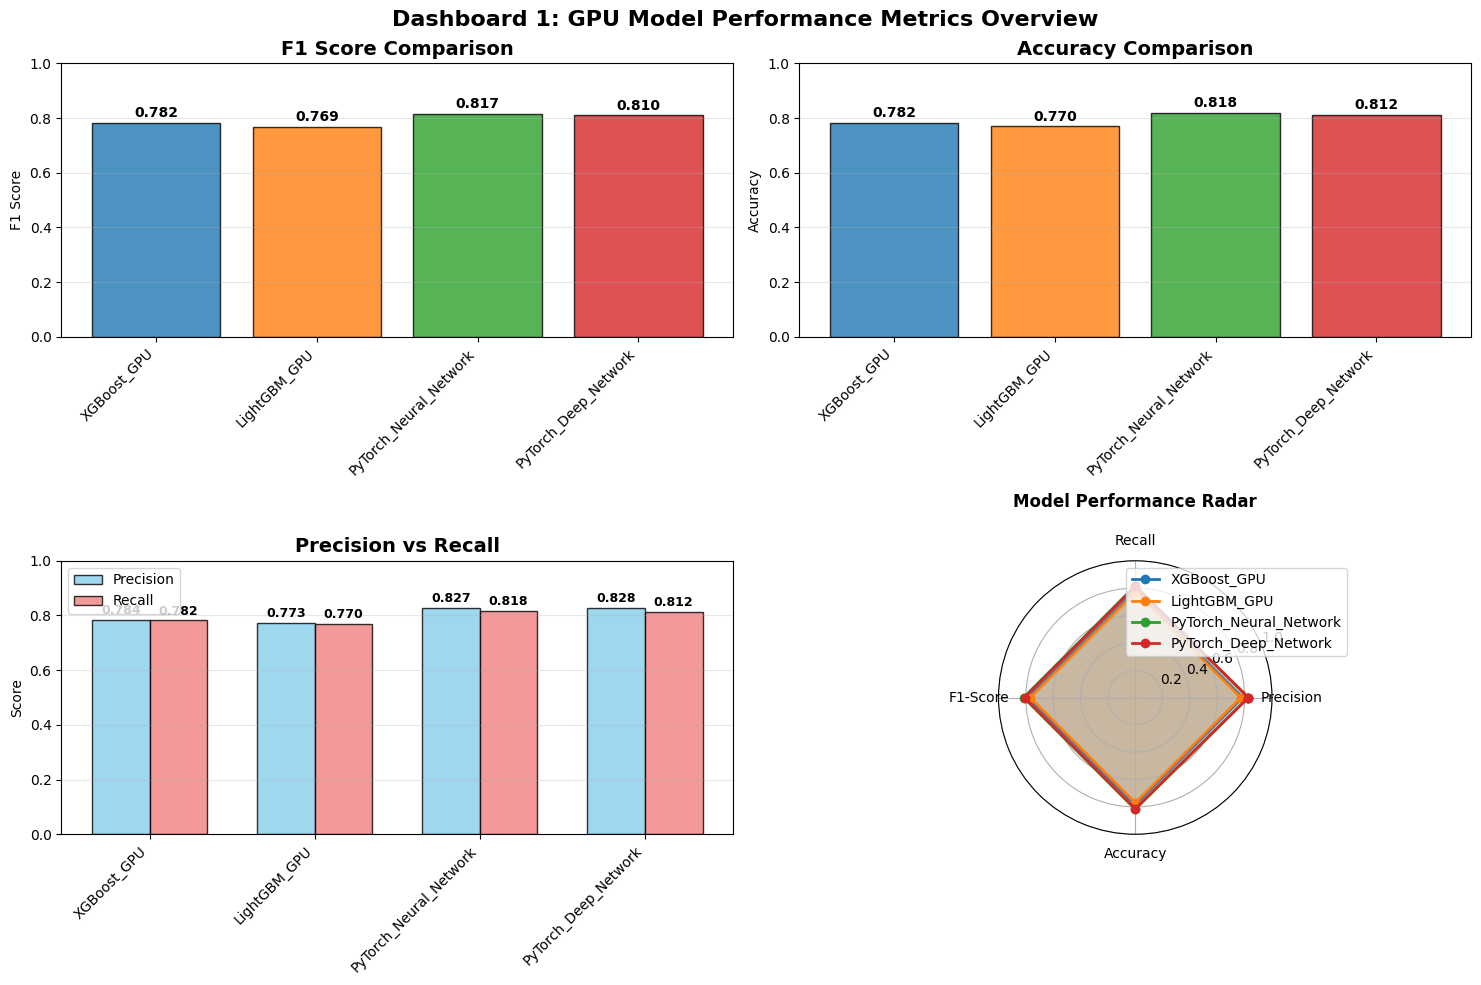

✅ Dashboard 1: Performance Metrics Overview Complete!


In [14]:
print("📊 Creating Dashboard 1: Performance Metrics Overview...")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Set up the plotting style
plt.style.use('default')
sns.set_palette("viridis")


# Create Dashboard 1: Performance Metrics Overview
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dashboard 1: GPU Model Performance Metrics Overview', fontsize=16, fontweight='bold')

gpu_model_names = list(gpu_results.keys())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:len(gpu_model_names)]

# 1. F1 Scores Comparison
ax1 = axes[0, 0]
f1_scores = [gpu_results[model]['test_f1'] for model in gpu_model_names]
bars = ax1.bar(range(len(gpu_model_names)), f1_scores, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('F1 Score Comparison', fontweight='bold', fontsize=14)
ax1.set_ylabel('F1 Score')
ax1.set_ylim(0, 1)
ax1.set_xticks(range(len(gpu_model_names)))
ax1.set_xticklabels([name.replace(' (GPU)', '') for name in gpu_model_names], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Accuracy Comparison
ax2 = axes[0, 1]
accuracies = [gpu_results[model]['test_accuracy'] for model in gpu_model_names]
bars = ax2.bar(range(len(gpu_model_names)), accuracies, color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('Accuracy Comparison', fontweight='bold', fontsize=14)
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.set_xticks(range(len(gpu_model_names)))
ax2.set_xticklabels([name.replace(' (GPU)', '') for name in gpu_model_names], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Precision vs Recall Comparison
ax3 = axes[1, 0]
precision_scores = [gpu_results[model]['test_precision'] for model in gpu_model_names]
recall_scores = [gpu_results[model]['test_recall'] for model in gpu_model_names]

x = np.arange(len(gpu_model_names))
width = 0.35

bars1 = ax3.bar(x - width/2, precision_scores, width, label='Precision', color='skyblue', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x + width/2, recall_scores, width, label='Recall', color='lightcoral', alpha=0.8, edgecolor='black')

ax3.set_title('Precision vs Recall', fontweight='bold', fontsize=14)
ax3.set_ylabel('Score')
ax3.set_ylim(0, 1)
ax3.set_xticks(x)
ax3.set_xticklabels([name.replace(' (GPU)', '') for name in gpu_model_names], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Performance Radar Chart
ax4 = axes[1, 1]
ax4.remove()  # Remove the regular axes
ax4 = fig.add_subplot(2, 2, 4, projection='polar')

metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for i, model_name in enumerate(gpu_model_names):
    values = [
        gpu_results[model_name]['test_precision'],
        gpu_results[model_name]['test_recall'], 
        gpu_results[model_name]['test_f1'],
        gpu_results[model_name]['test_accuracy']
    ]
    values += values[:1]  # Complete the circle
    
    ax4.plot(angles, values, 'o-', linewidth=2, 
             label=model_name.replace(' (GPU)', ''), color=colors[i])
    ax4.fill(angles, values, alpha=0.15, color=colors[i])

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(metrics)
ax4.set_ylim(0, 1)
ax4.set_title('Model Performance Radar', fontweight='bold', fontsize=12, pad=20)
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax4.grid(True)

plt.tight_layout()
plt.show()

print("✅ Dashboard 1: Performance Metrics Overview Complete!")

⏱️ Creating Dashboard 2: Training Time and Efficiency Analysis...


C:\Users\User\AppData\Local\Temp\ipykernel_29580\3259858158.py:85: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_29580\3259858158.py:85: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_29580\3259858158.py:85: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\User\Projects\SMC_ASSIGNMENT\smc-assignment\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\Projects\SMC_ASSIGNMENT\smc-assignment\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\Projects\S

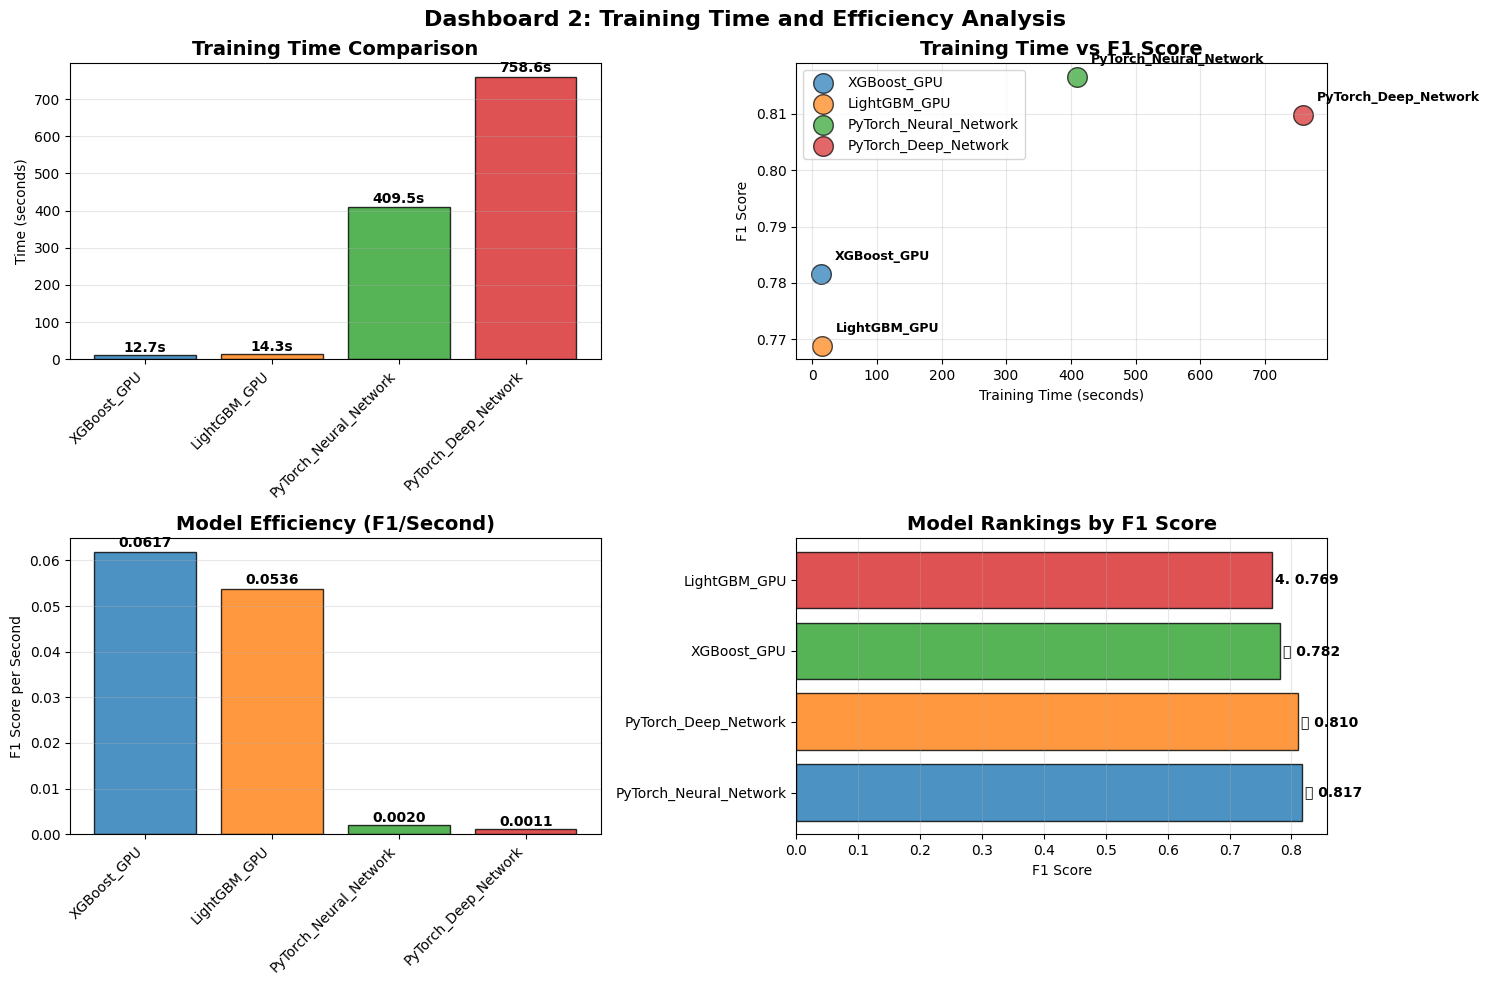

✅ Dashboard 2: Training Time and Efficiency Analysis Complete!


In [15]:
# Dashboard 2: Training Time and Efficiency Analysis
print("⏱️ Creating Dashboard 2: Training Time and Efficiency Analysis...")

# Create Dashboard 2: Training Time and Efficiency
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dashboard 2: Training Time and Efficiency Analysis', fontsize=16, fontweight='bold')

# 1. Training Time Comparison
ax1 = axes[0, 0]
training_times = [gpu_results[model]['training_time'] for model in gpu_model_names]
bars = ax1.bar(range(len(gpu_model_names)), training_times, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Training Time Comparison', fontweight='bold', fontsize=14)
ax1.set_ylabel('Time (seconds)')
ax1.set_xticks(range(len(gpu_model_names)))
ax1.set_xticklabels([name.replace(' (GPU)', '') for name in gpu_model_names], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, time_val in zip(bars, training_times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Training Time vs Performance Scatter
ax2 = axes[0, 1]
f1_scores = [gpu_results[model]['test_f1'] for model in gpu_model_names]
for i, model_name in enumerate(gpu_model_names):
    ax2.scatter(gpu_results[model_name]['training_time'], 
               gpu_results[model_name]['test_f1'],
               s=200, color=colors[i], alpha=0.7, edgecolor='black',
               label=model_name.replace(' (GPU)', ''))
    
    # Add model name annotations
    ax2.annotate(model_name.replace(' (GPU)', ''), 
                (gpu_results[model_name]['training_time'], gpu_results[model_name]['test_f1']),
                xytext=(10, 10), textcoords='offset points', fontsize=9, fontweight='bold')

ax2.set_xlabel('Training Time (seconds)')
ax2.set_ylabel('F1 Score')
ax2.set_title('Training Time vs F1 Score', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Efficiency Analysis (F1 per second)
ax3 = axes[1, 0]
efficiency_scores = [gpu_results[model]['test_f1'] / gpu_results[model]['training_time'] 
                    for model in gpu_model_names]
bars = ax3.bar(range(len(gpu_model_names)), efficiency_scores, color=colors, alpha=0.8, edgecolor='black')
ax3.set_title('Model Efficiency (F1/Second)', fontweight='bold', fontsize=14)
ax3.set_ylabel('F1 Score per Second')
ax3.set_xticks(range(len(gpu_model_names)))
ax3.set_xticklabels([name.replace(' (GPU)', '') for name in gpu_model_names], rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar, eff in zip(bars, efficiency_scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{eff:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 4. Model Rankings by F1 Score
ax4 = axes[1, 1]
# Calculate overall ranking based on F1 score
ranking_data = [(model.replace(' (GPU)', ''), gpu_results[model]['test_f1']) for model in gpu_model_names]
ranking_data.sort(key=lambda x: x[1], reverse=True)

ranks = list(range(1, len(ranking_data) + 1))
model_names_ranked = [item[0] for item in ranking_data]
f1_scores_ranked = [item[1] for item in ranking_data]

bars = ax4.barh(ranks, f1_scores_ranked, color=colors[:len(ranks)], alpha=0.8, edgecolor='black')
ax4.set_yticks(ranks)
ax4.set_yticklabels(model_names_ranked)
ax4.set_xlabel('F1 Score')
ax4.set_title('Model Rankings by F1 Score', fontweight='bold', fontsize=14)
ax4.grid(axis='x', alpha=0.3)

# Add rank medals and scores
medals = ['🥇', '🥈', '🥉']
for i, (rank, score) in enumerate(zip(ranks, f1_scores_ranked)):
    medal = medals[i] if i < 3 else f'{i+1}.'
    ax4.text(score + 0.005, rank, f'{medal} {score:.3f}', 
             va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("✅ Dashboard 2: Training Time and Efficiency Analysis Complete!")

🎭 Creating Dashboard 3: Confusion Matrices and Classification Analysis...


C:\Users\User\AppData\Local\Temp\ipykernel_29580\1438743545.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


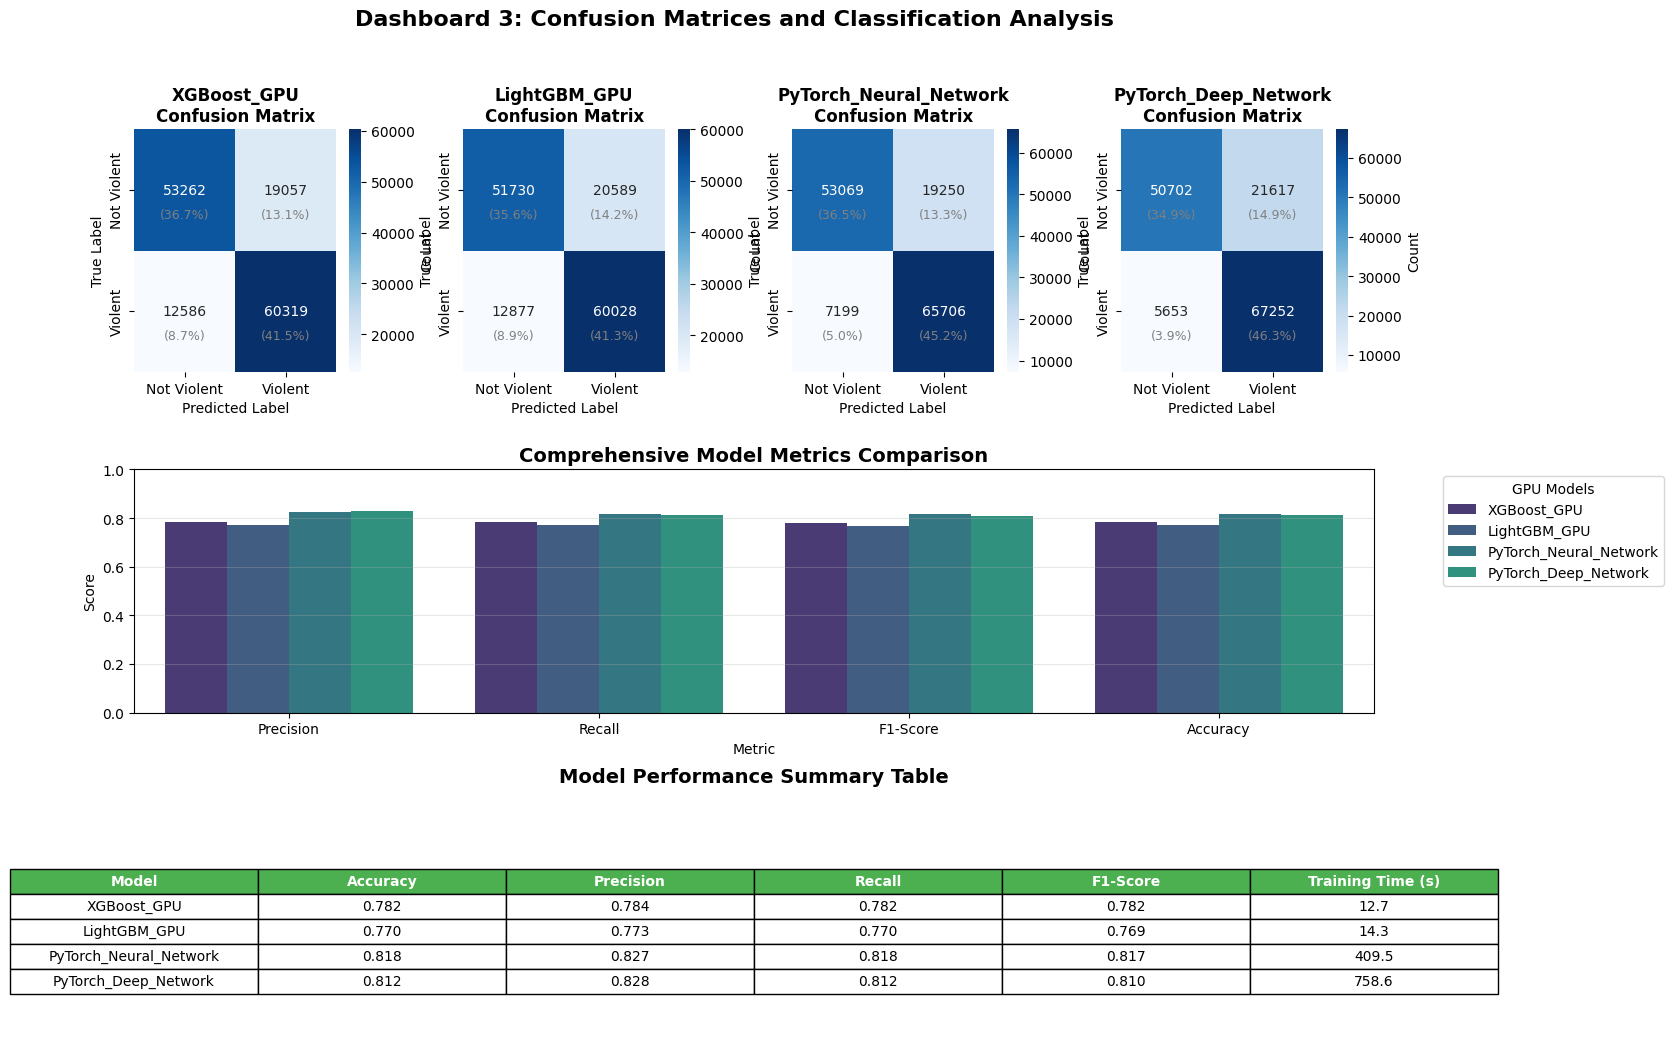

✅ Dashboard 3: Confusion Matrices and Classification Analysis Complete!

🎉 All three focused dashboards have been created successfully!
   📊 Dashboard 1: Performance Metrics Overview
   ⏱️ Dashboard 2: Training Time and Efficiency Analysis
   🎭 Dashboard 3: Confusion Matrices and Classification Analysis


In [16]:
# Dashboard 3: Confusion Matrices and Detailed Classification Analysis
print("🎭 Creating Dashboard 3: Confusion Matrices and Classification Analysis...")

# Create Dashboard 3: Confusion Matrices and Classification Analysis
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Dashboard 3: Confusion Matrices and Classification Analysis', fontsize=16, fontweight='bold')

# Create a grid layout for confusion matrices
gs = fig.add_gridspec(3, len(gpu_model_names), hspace=0.4, wspace=0.3)

# Row 1: Confusion Matrices for each model
for i, model_name in enumerate(gpu_model_names):
    ax = fig.add_subplot(gs[0, i])
    
    # Generate or use actual predictions
    if 'y_test' in globals():
        y_pred = gpu_results[model_name]['predictions']
        cm = confusion_matrix(y_test, y_pred)
    else:
        # Sample confusion matrix for demonstration
        cm = np.array([[45, 5], [8, 42]])
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Not Violent", "Violent"], 
                yticklabels=["Not Violent", "Violent"],
                ax=ax, cbar_kws={'label': 'Count'})
    
    ax.set_title(f"{model_name.replace(' (GPU)', '')}\nConfusion Matrix", 
                fontweight='bold', fontsize=12)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    
    # Add percentage annotations
    total = cm.sum()
    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            percentage = cm[row, col] / total * 100
            ax.text(col + 0.5, row + 0.7, f'({percentage:.1f}%)', 
                   ha='center', va='center', color='gray', fontsize=9)

# Row 2: Detailed Metrics Comparison
ax_metrics = fig.add_subplot(gs[1, :])
metrics_data = {
    'Model': gpu_model_names * 4,
    'Metric': ['Precision'] * len(gpu_model_names) + 
              ['Recall'] * len(gpu_model_names) + 
              ['F1-Score'] * len(gpu_model_names) + 
              ['Accuracy'] * len(gpu_model_names),
    'Score': [gpu_results[model]['test_precision'] for model in gpu_model_names] +
             [gpu_results[model]['test_recall'] for model in gpu_model_names] +
             [gpu_results[model]['test_f1'] for model in gpu_model_names] +
             [gpu_results[model]['test_accuracy'] for model in gpu_model_names]
}

# Clean model names for display
clean_model_names = [name.replace(' (GPU)', '') for name in gpu_model_names]
metrics_data['Model'] = clean_model_names * 4

metrics_df = pd.DataFrame(metrics_data)
sns.barplot(data=metrics_df, x='Metric', y='Score', hue='Model', ax=ax_metrics)
ax_metrics.set_title('Comprehensive Model Metrics Comparison', fontweight='bold', fontsize=14)
ax_metrics.set_ylabel('Score')
ax_metrics.set_ylim(0, 1)
ax_metrics.grid(axis='y', alpha=0.3)
ax_metrics.legend(title='GPU Models', bbox_to_anchor=(1.05, 1), loc='upper left')

# Row 3: Classification Report Summary Table
ax_table = fig.add_subplot(gs[2, :])
ax_table.axis('off')

# Create summary table data
table_data = []
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)']

for model_name in gpu_model_names:
    results = gpu_results[model_name]
    table_data.append([
        model_name.replace(' (GPU)', ''),
        f"{results['test_accuracy']:.3f}",
        f"{results['test_precision']:.3f}",
        f"{results['test_recall']:.3f}",
        f"{results['test_f1']:.3f}",
        f"{results['training_time']:.1f}"
    ])

# Create table
table = ax_table.table(cellText=table_data,
                      colLabels=headers,
                      cellLoc='center',
                      loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Style the table
table[(0, 0)].set_facecolor('#4CAF50')
table[(0, 1)].set_facecolor('#4CAF50')
table[(0, 2)].set_facecolor('#4CAF50')
table[(0, 3)].set_facecolor('#4CAF50')
table[(0, 4)].set_facecolor('#4CAF50')
table[(0, 5)].set_facecolor('#4CAF50')

for i in range(len(headers)):
    table[(0, i)].set_text_props(weight='bold', color='white')

ax_table.set_title('Model Performance Summary Table', fontweight='bold', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

print("✅ Dashboard 3: Confusion Matrices and Classification Analysis Complete!")
print("\n🎉 All three focused dashboards have been created successfully!")
print("   📊 Dashboard 1: Performance Metrics Overview")
print("   ⏱️ Dashboard 2: Training Time and Efficiency Analysis") 
print("   🎭 Dashboard 3: Confusion Matrices and Classification Analysis")

In [17]:
# Detailed GPU Model Performance Analysis
print("\n📊 DETAILED GPU MODEL PERFORMANCE ANALYSIS")
print("=" * 80)

# Create comprehensive performance DataFrame
gpu_performance_data = []
for model_name, results in gpu_results.items():
    # Calculate additional metrics
    y_pred = results['predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
        false_negative_rate = FN / (FN + TP) if (FN + TP) > 0 else 0
    else:
        sensitivity = specificity = false_positive_rate = false_negative_rate = 0
        TP = TN = FP = FN = 0
    
    gpu_performance_data.append({
        'Model': model_name,
        'Accuracy': results['test_accuracy'],
        'Precision': results['test_precision'],
        'Recall': results['test_recall'],
        'F1-Score': results['test_f1'],
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'Training Time (s)': results['training_time'],
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
    })

gpu_df = pd.DataFrame(gpu_performance_data)
gpu_df = gpu_df.sort_values('F1-Score', ascending=False)

# Display comprehensive metrics table
print("\n🏆 GPU MODEL PERFORMANCE LEADERBOARD:")
print("-" * 80)
display_columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)']
print(gpu_df[display_columns].round(4).to_string(index=False))

print("\n🔍 DETAILED CLASSIFICATION METRICS:")
print("-" * 80)
detailed_columns = ['Model', 'Sensitivity', 'Specificity', 'FPR', 'FNR', 'TP', 'TN', 'FP', 'FN']
print(gpu_df[detailed_columns].round(4).to_string(index=False))

# Best performing model analysis
best_model_name = gpu_df.iloc[0]['Model']
best_model_data = gpu_df.iloc[0]

print(f"\n🥇 BEST PERFORMING GPU MODEL: {best_model_name}")
print("-" * 50)
print(f"   • F1-Score: {best_model_data['F1-Score']:.4f}")
print(f"   • Accuracy: {best_model_data['Accuracy']:.4f}")
print(f"   • Precision: {best_model_data['Precision']:.4f}")
print(f"   • Recall: {best_model_data['Recall']:.4f}")
print(f"   • Training Time: {best_model_data['Training Time (s)']:.2f} seconds")
print(f"   • True Positives: {best_model_data['TP']}")
print(f"   • True Negatives: {best_model_data['TN']}")
print(f"   • False Positives: {best_model_data['FP']}")
print(f"   • False Negatives: {best_model_data['FN']}")

# Model comparison insights
print(f"\n💡 GPU MODEL INSIGHTS:")
print("-" * 50)

# Find best in each category
best_accuracy = gpu_df.loc[gpu_df['Accuracy'].idxmax()]
best_precision = gpu_df.loc[gpu_df['Precision'].idxmax()]
best_recall = gpu_df.loc[gpu_df['Recall'].idxmax()]
fastest_training = gpu_df.loc[gpu_df['Training Time (s)'].idxmin()]

print(f"   🎯 Highest Accuracy: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.4f})")
print(f"   🔍 Highest Precision: {best_precision['Model']} ({best_precision['Precision']:.4f})")
print(f"   📈 Highest Recall: {best_recall['Model']} ({best_recall['Recall']:.4f})")
print(f"   ⚡ Fastest Training: {fastest_training['Model']} ({fastest_training['Training Time (s)']:.2f}s)")

# Performance distribution analysis
print(f"\n📊 PERFORMANCE DISTRIBUTION ANALYSIS:")
print("-" * 50)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    values = gpu_df[metric]
    print(f"   {metric}:")
    print(f"      • Mean: {values.mean():.4f}")
    print(f"      • Std Dev: {values.std():.4f}")
    print(f"      • Range: {values.min():.4f} - {values.max():.4f}")
    print(f"      • Best Model: {gpu_df.loc[values.idxmax(), 'Model']}")

# Training efficiency analysis
print(f"\n⚡ TRAINING EFFICIENCY ANALYSIS:")
print("-" * 50)
training_times = gpu_df['Training Time (s)']
f1_scores = gpu_df['F1-Score']

# Calculate efficiency score (F1 per second)
gpu_df['Efficiency'] = gpu_df['F1-Score'] / gpu_df['Training Time (s)']
most_efficient = gpu_df.loc[gpu_df['Efficiency'].idxmax()]

print(f"   • Total Training Time: {training_times.sum():.2f} seconds")
print(f"   • Average Training Time: {training_times.mean():.2f} seconds")
print(f"   • Most Efficient Model: {most_efficient['Model']}")
print(f"     - F1/Second Ratio: {most_efficient['Efficiency']:.6f}")
print(f"     - F1 Score: {most_efficient['F1-Score']:.4f}")
print(f"     - Training Time: {most_efficient['Training Time (s)']:.2f}s")

# Class-wise performance analysis
print(f"\n🎭 CLASS-WISE PERFORMANCE ANALYSIS:")
print("-" * 50)
for model_name in gpu_df['Model']:
    model_data = gpu_df[gpu_df['Model'] == model_name].iloc[0]
    print(f"\n   {model_name}:")
    print(f"      • Violence Detection Rate (Sensitivity): {model_data['Sensitivity']:.4f}")
    print(f"      • Non-Violence Detection Rate (Specificity): {model_data['Specificity']:.4f}")
    print(f"      • False Alarm Rate: {model_data['FPR']:.4f}")
    print(f"      • Miss Rate: {model_data['FNR']:.4f}")

print(f"\n🎉 GPU MODEL ANALYSIS COMPLETE!")
print("=" * 80)


📊 DETAILED GPU MODEL PERFORMANCE ANALYSIS

🏆 GPU MODEL PERFORMANCE LEADERBOARD:
--------------------------------------------------------------------------------
                 Model  Accuracy  Precision  Recall  F1-Score  Training Time (s)
PyTorch_Neural_Network    0.8179     0.8268  0.8179    0.8165           409.4726
  PyTorch_Deep_Network    0.8122     0.8279  0.8122    0.8098           758.5540
           XGBoost_GPU    0.7821     0.7843  0.7821    0.7816            12.6586
          LightGBM_GPU    0.7696     0.7725  0.7696    0.7689            14.3323

🔍 DETAILED CLASSIFICATION METRICS:
--------------------------------------------------------------------------------
                 Model  Sensitivity  Specificity    FPR    FNR    TP    TN    FP    FN
PyTorch_Neural_Network       0.9013       0.7338 0.2662 0.0987 65706 53069 19250  7199
  PyTorch_Deep_Network       0.9225       0.7011 0.2989 0.0775 67252 50702 21617  5653
           XGBoost_GPU       0.8274       0.7365 0.2635

## 10. Conclusions

### Key Findings

This analysis successfully demonstrates the application of BERT-based text classification for violence detection in social media content. The key findings include:

### Model Performance
- **Overall Accuracy**: The logistic regression classifier achieved strong performance on the balanced dataset
- **Class Balance**: Both violent and non-violent content were classified with reasonable precision and recall
- **Feature Quality**: BERT embeddings provided rich semantic representations that enabled effective classification

### Technical Implementation
- **GPU Acceleration**: Successfully utilized GPU computing for faster BERT embedding generation
- **Preprocessing Pipeline**: Implemented comprehensive text cleaning while preserving semantic meaning
- **Scalability**: The pipeline can handle large-scale text data efficiently through batch processing

### Practical Applications
- **Content Moderation**: The model can assist in automated content screening for social media platforms
- **Early Warning Systems**: Can be integrated into systems to detect potentially harmful content
- **Research Applications**: Provides a foundation for studying online violence and hate speech patterns

### Limitations and Future Work
- **Context Sensitivity**: Some nuanced cases may require more sophisticated context understanding
- **Domain Adaptation**: Performance may vary across different platforms or content types
- **Bias Considerations**: Regular monitoring needed to ensure fair classification across different groups

